In [1]:
from sklearn.cluster import KMeans
import numpy as np
import scipy as sp
import sys
sys.path.append('../corv/src')
sys.path.append('../wdtools')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
import pandas as pd
import corv

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c
import data_selector as ds

import wdtools
import corv


using local paths
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


2022-08-09 10:48:15.771483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-09 10:48:15.771572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Please install galpy if you want to use the gaia module. otherwise, ignore this.


In [2]:
#d1 = pd.read_csv('data/wd_spectra.csv')
#d1 = Table.from_pandas(d1)

catalog = Table.read('data/00_raw.fits')
print(len(catalog))

1733


In [3]:
#spAll = Table.read('~/Downloads/spAll-master.fits')

In [4]:
'''
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join_skycoord
from astropy import table

print(spAll.keys())

print(spAll[['RACAT', 'DECCAT']])

spAll = spAll[spAll['DECCAT'] < 90]
spAll = spAll[spAll['DECCAT'] > -90]

catalog['wd_pos'] = SkyCoord(catalog['wd_ra'], catalog['wd_dec'], unit='deg')
spAll['wd_pos'] = SkyCoord(spAll['RACAT'], spAll['DECCAT'], unit='deg')

join_func = table.join_skycoord(5 * u.arcsecond)
sdss5_catalog = table.join(catalog, spAll, join_funcs={'wd_pos': join_skycoord(5 * u.arcsec)})
'''

"\nfrom astropy.coordinates import SkyCoord\nimport astropy.units as u\nfrom astropy.table import Table, join_skycoord\nfrom astropy import table\n\nprint(spAll.keys())\n\nprint(spAll[['RACAT', 'DECCAT']])\n\nspAll = spAll[spAll['DECCAT'] < 90]\nspAll = spAll[spAll['DECCAT'] > -90]\n\ncatalog['wd_pos'] = SkyCoord(catalog['wd_ra'], catalog['wd_dec'], unit='deg')\nspAll['wd_pos'] = SkyCoord(spAll['RACAT'], spAll['DECCAT'], unit='deg')\n\njoin_func = table.join_skycoord(5 * u.arcsecond)\nsdss5_catalog = table.join(catalog, spAll, join_funcs={'wd_pos': join_skycoord(5 * u.arcsec)})\n"

In [5]:
#print(sdss5_catalog[['wd_pos_id', 'wd_pos_1', 'wd_pos_2']])

In [6]:
ADQL_CODE1 = "SELECT \
        sdss.original_ext_source_id as bestobjid,\
        gaia_source.source_id\
        FROM gaiaedr3.gaia_source \
        JOIN gaiaedr3.sdssdr13_best_neighbour as sdss\
        ON gaia_source.source_id = sdss.source_id      \
        WHERE gaia_source.source_id IN {}\
    ".format(tuple(catalog['wd_source_id']))

job1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False)
d1 = job1.get_results()
print(len(d1))

658


In [7]:
drops = []
bestobjid1 = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(d1['source_id'] == catalog['wd_source_id'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        try:
            bestobjid1.append(d1['bestobjid'][j])
        except:
            notfound = True
    if notfound:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['wd_bestobjid'] = bestobjid1

100%|█████████████████████████████████████████████████████████████████████| 1733/1733 [00:00<00:00, 8296.63it/s]


In [8]:
print(catalog['wd_bestobjid'])

    wd_bestobjid   
-------------------
1237667136955416672
1237666464265994487
1237667207828799608
1237667205679677575
1237663230147231754
1237667111726219327
1237664668973989935
1237662224056188974
1237667255616209053
1237667255615750198
1237665127465156659
                ...
1237662530608169046
1237662198815457306
1237662530607644949
1237668311090593860
1237668336321495175
1237665547825185381
1237667782320324692
1237665566081679524
1237667735599841356
1237667782856147342
1237663787955978273
Length = 658 rows


In [9]:
from astropy.table import Table, vstack, hstack

stardats = []
iters = len(catalog) // 100

for i in tqdm(range(iters)):
    SDSS_QUERY = """select bestObjID, plate, mjd, fiberID, subClass
        from dbo.SpecObjAll
        where bestObjID in {}""".format(tuple(catalog['wd_bestobjid'][100*i:100*i+100]))
    
    stardats.append(SDSS.query_sql(SDSS_QUERY))
spec = vstack(stardats)


  0%|                                                                                     | 0/6 [00:00<?, ?it/s]/home/arseneausm/anaconda3/lib/python3.8/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
100%|█████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.85it/s]


In [10]:
print(spec)


     bestObjID      plate  mjd  fiberID    subClass   
------------------- ----- ----- ------- --------------
1237670965918892088  2428 53801     598             G0
1237667782819840005  5782 56272     260       WDcooler
1237667429019418713  2439 53795     448             CV
1237667255077175502  2347 53757     531             M2
1237667255077175502  2386 54064     563               
1237667254002122820  2344 53740     181             CV
1237667113872982045  5794 56282     772       WDhotter
1237667113872982045  2342 53742     380             WD
1237667108500603237  2273 53709     495               
1237666407379173438  4231 55444     492 K1IVa (142091)
1237664835385688318  1921 53317     625             A0
                ...   ...   ...     ...            ...
1237671123220365549  1758 53084     530             WD
1237667551953420367  2352 53770     127             WD
1237667550341496885  2366 53741     496             WD
1237667324336930835  6000 56102     536               
1237657595

In [11]:

drops = []
plate = []
mjd = []
fiber = []
types = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(spec['bestObjID'] == catalog['wd_bestobjid'][i])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        try:
            
            plate.append(spec['plate'][j])
            mjd.append(spec['mjd'][j])
            fiber.append(spec['fiberID'][j])
            types.append(spec['subClass'][j])
            
            
        except:
            notfound = True
    if notfound:
        drops.append(i)    
        
catalog.remove_rows(drops)
catalog['plate'] = plate
catalog['mjd'] = mjd
catalog['fiber'] = fiber
catalog['subClass'] = types


100%|██████████████████████████████████████████████████████████████████████| 658/658 [00:00<00:00, 14128.09it/s]


In [12]:
print(len(catalog))

70


In [13]:
spec = []
wl = []
fl = []
ivar = []
drops = []
worked = []

for i in tqdm(range(len(catalog))):
    try:
        spec = SDSS.get_spectra_async(plate=plate[i], fiberID=fiber[i], mjd=mjd[i])[0].get_fits()
        
        #print(spec[4].header)
        
        wl.append(10**spec[1].data['loglam'])
        fl.append(spec[1].data['flux'])
        ivar.append(spec[1].data['ivar'])
        worked.append(i)
    except:
        drops.append(i)
        
print(len(wl))
print(len(fl))
print(len(ivar))
        
catalog.remove_rows(drops)
catalog['wd_wl'] = wl
catalog['wd_fl'] = fl
catalog['wd_ivar'] = ivar

  3%|██▏                                                                         | 2/70 [00:00<00:18,  3.74it/s]/home/arseneausm/anaconda3/lib/python3.8/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
100%|███████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 13.60it/s]

70
70
70


In [14]:
print(catalog['subClass'])

print(len(catalog))

 subClass
---------
       CV
       M2
       G0
 WDhotter
 WDhotter
       A0
         
 WDcooler
       CV
 WDhotter
       CV
      ...
BROADLINE
CalciumWD
       WD
       WD
 WDhotter
 WDhotter
       WD
       OB
       CV
         
         
Length = 70 rows
70


In [15]:
def pseudonormalize(fl, win = 50):
    cont_fl = np.repeat(np.nan, len(fl))
    
    for i in range(len(fl)):
        if (i - (win / 2)) < 0:
            fl_win = fl[0:(i + (win // 2))]
        else:
            fl_win = fl[(i - (win // 2)) : (i + (win // 2))]
        
        cont_fl[i] = np.percentile(fl_win, 90)
        
    return fl / cont_fl
'''
def spec_split(bands, wl, fl, window_size = 100):
    spec_split = {}
    
    for i in range(len(bands)):
        spec_split[bands.keys()[i]] = np.array([ [wl[
'''

'\ndef spec_split(bands, wl, fl, window_size = 100):\n    spec_split = {}\n    \n    for i in range(len(bands)):\n        spec_split[bands.keys()[i]] = np.array([ [wl[\n'

 29%|█████████████████████▍                                                     | 20/70 [00:13<00:27,  1.81it/s]/tmp/ipykernel_5198/660068074.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(30,12))
100%|███████████████████████████████████████████████████████████████████████████| 70/70 [00:42<00:00,  1.66it/s]


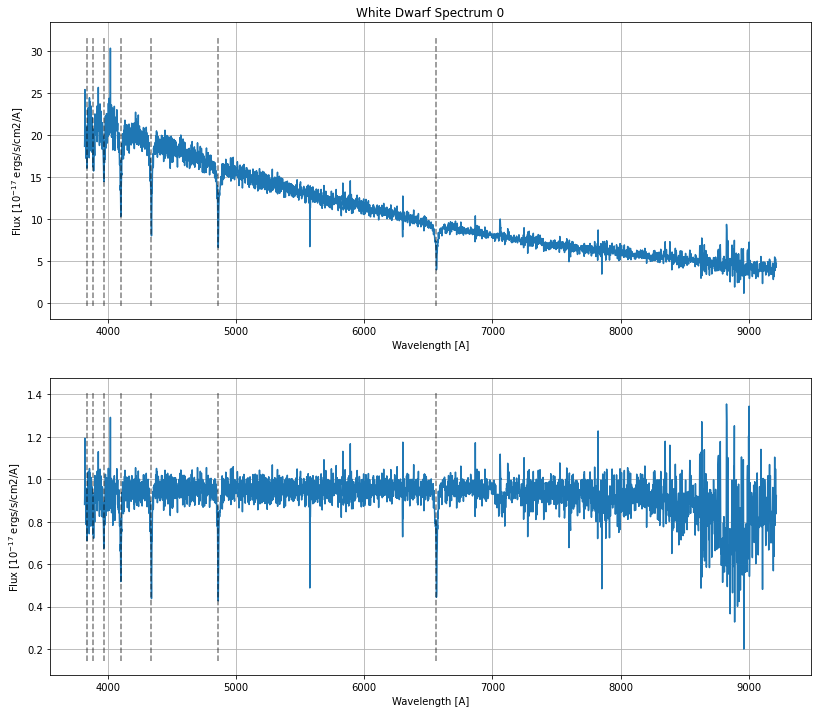

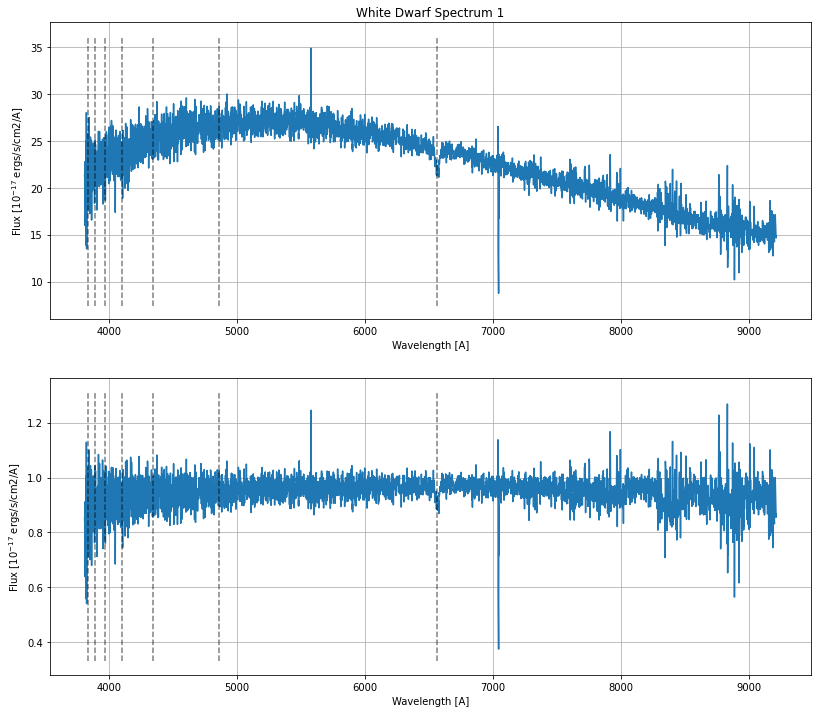

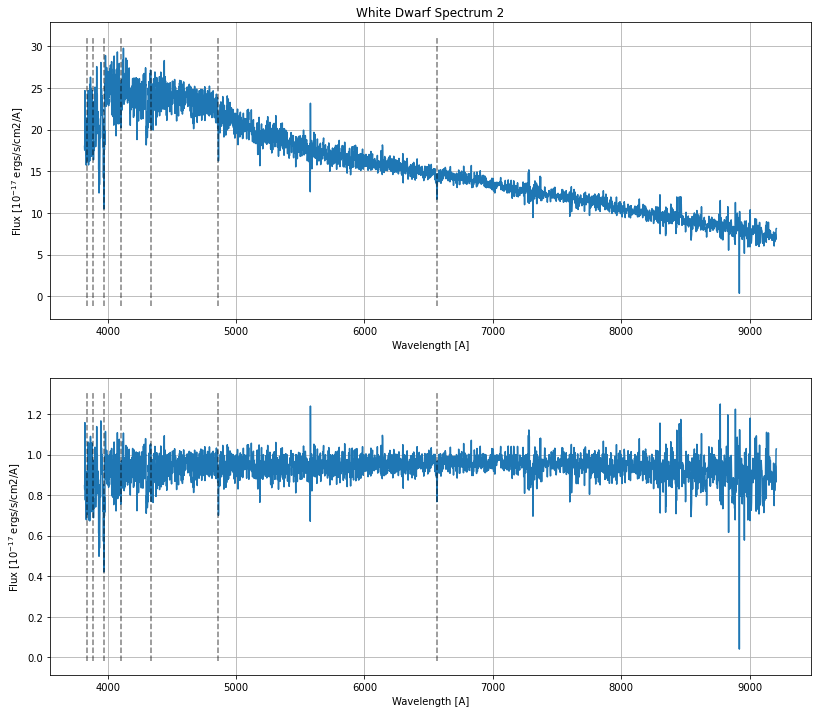

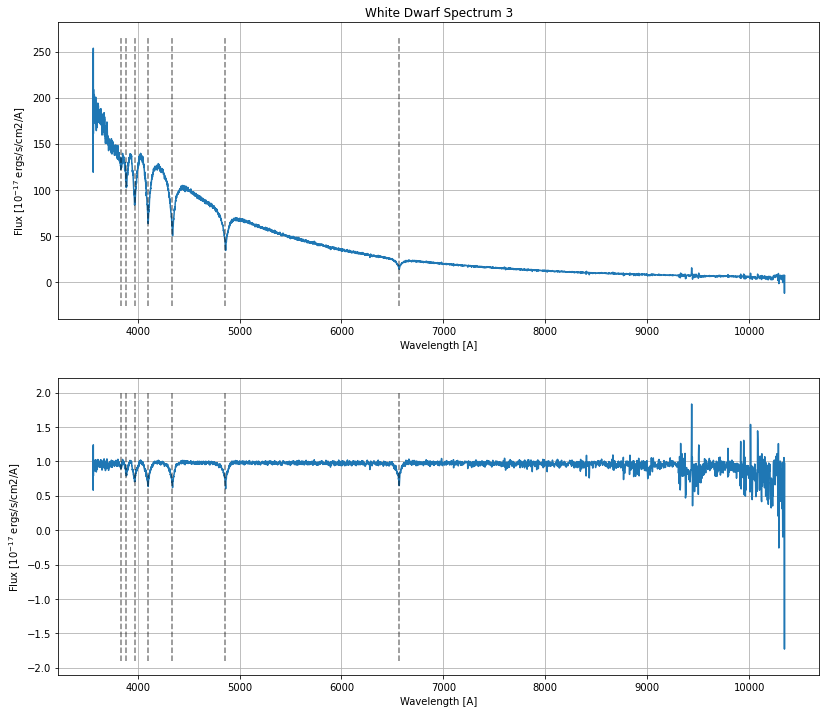

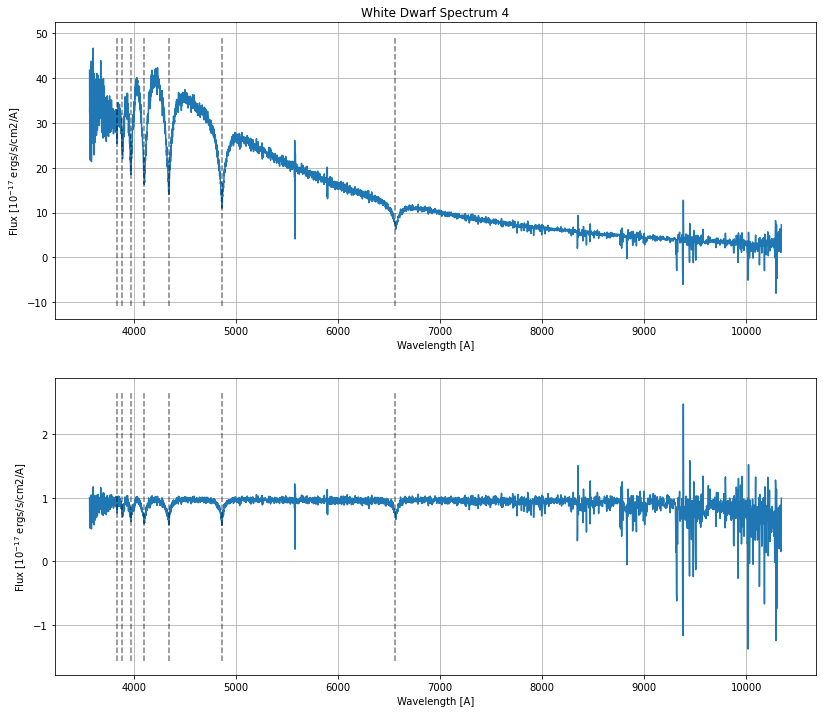

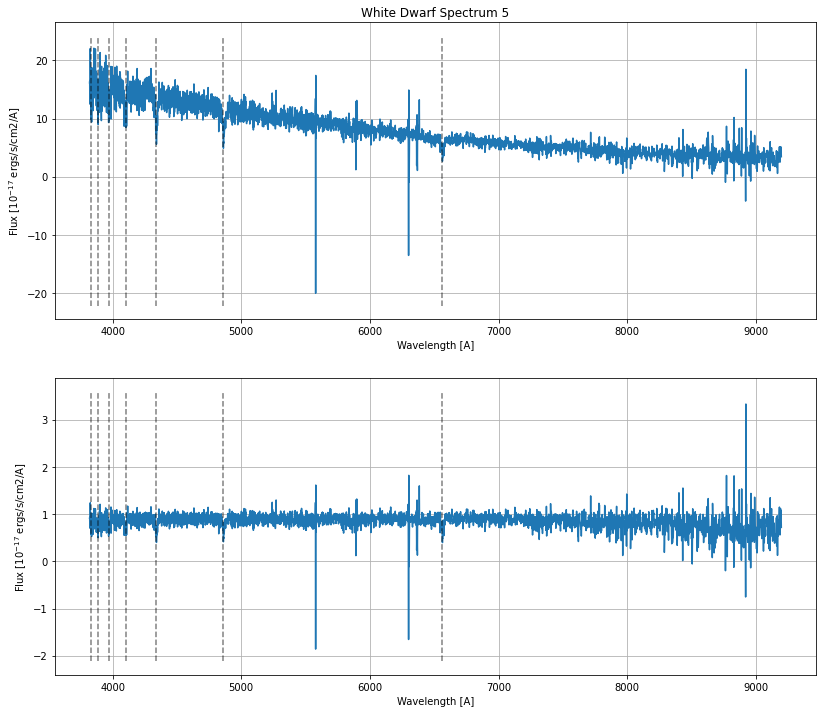

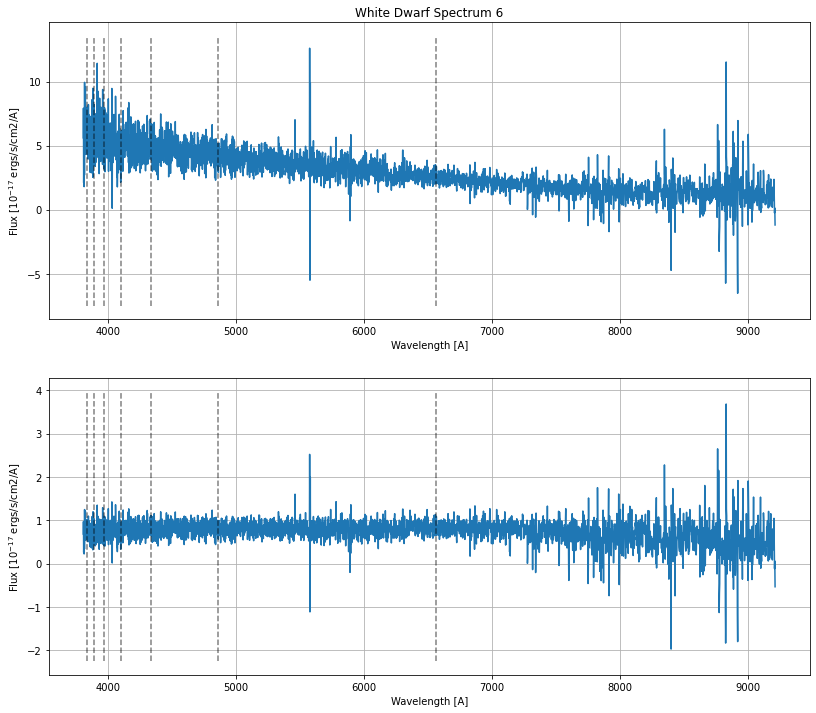

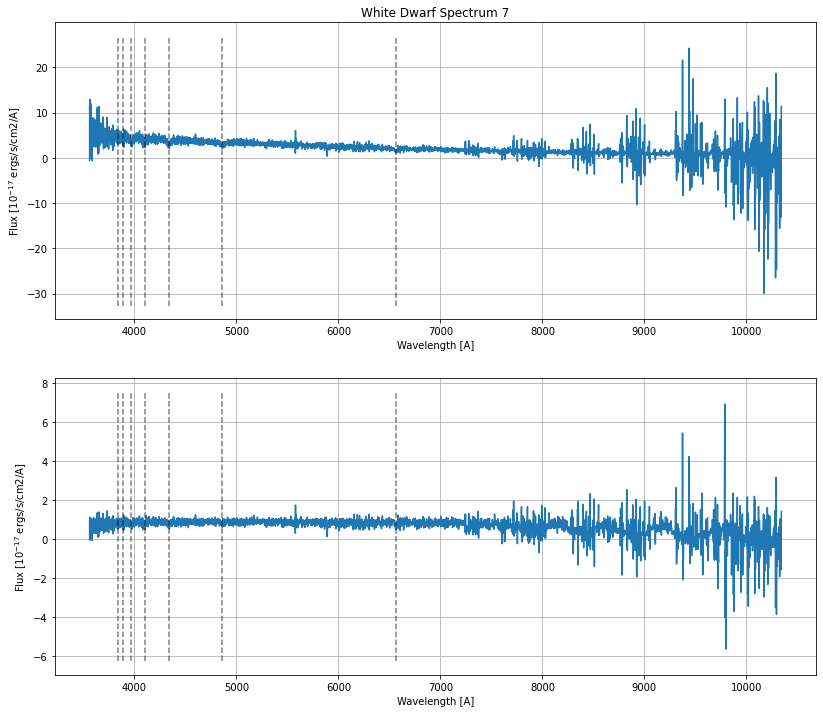

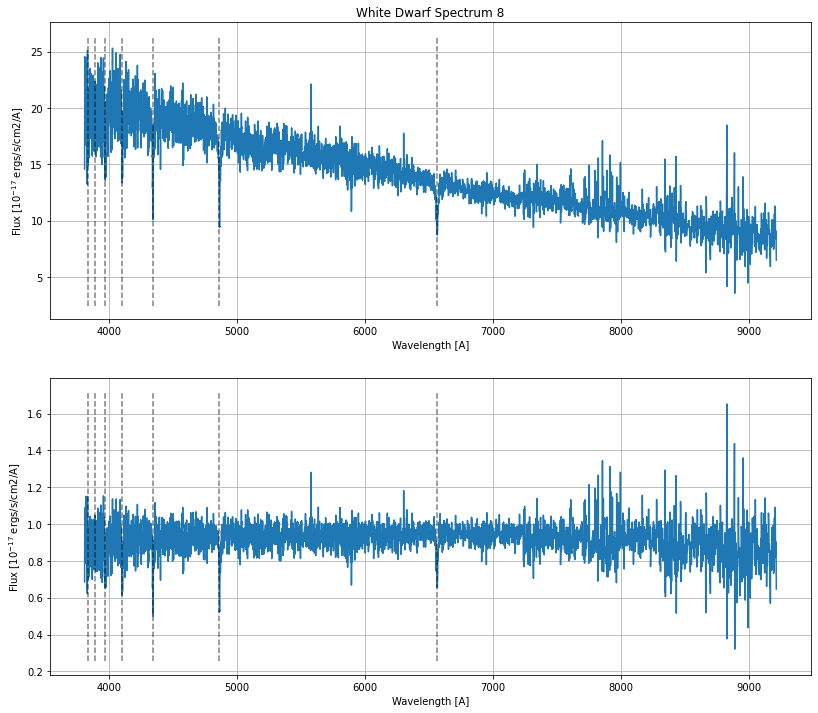

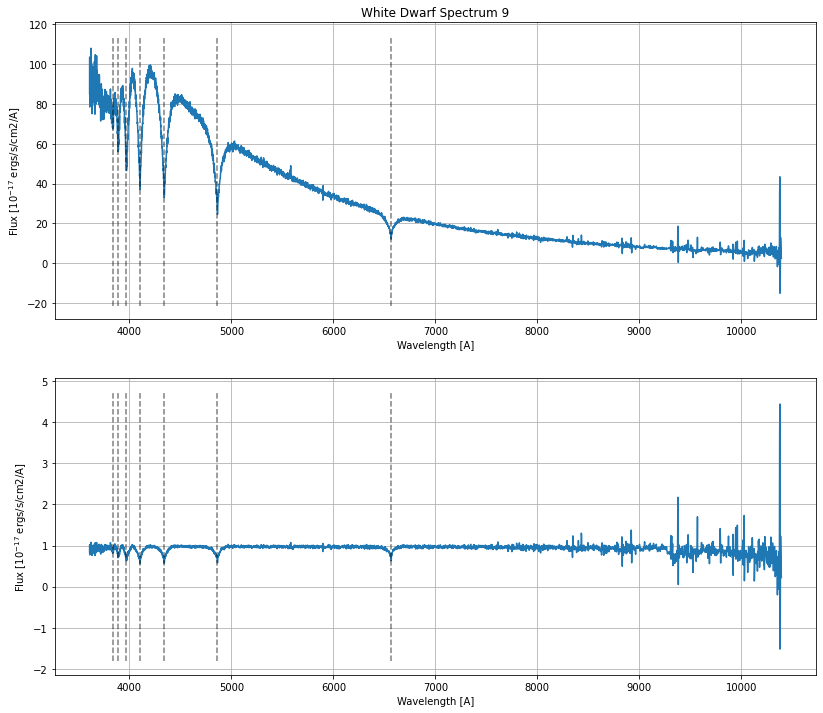

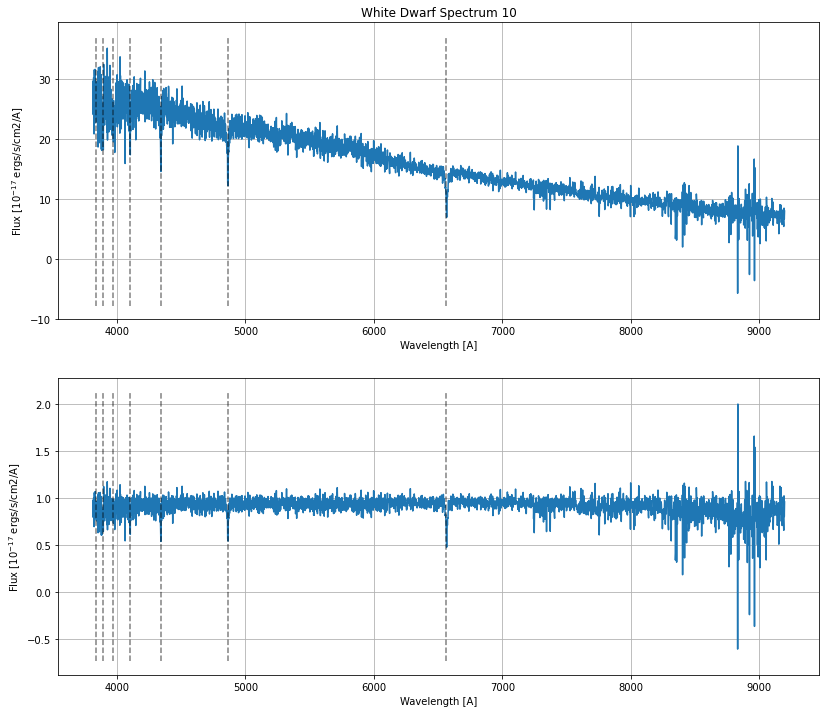

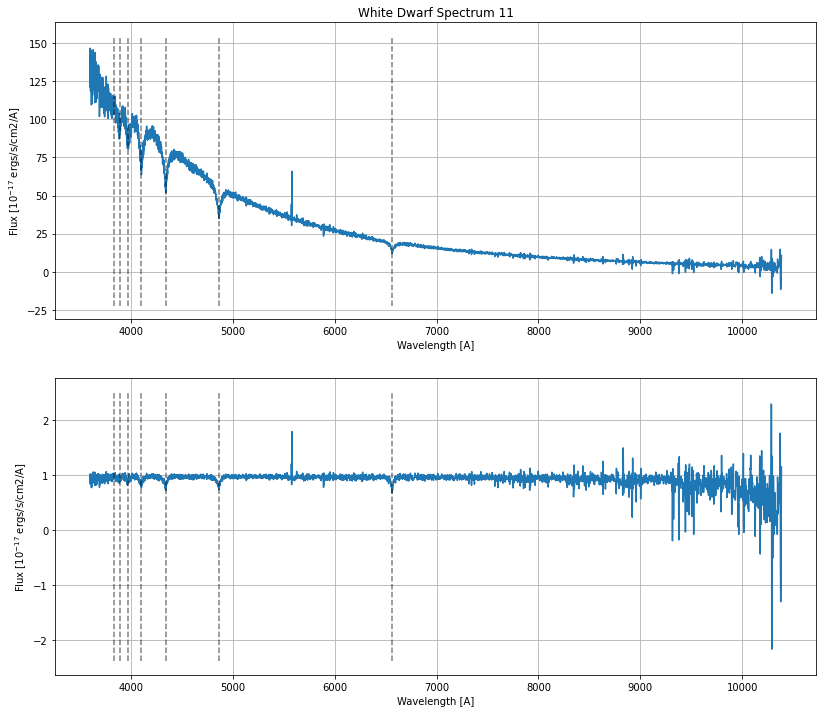

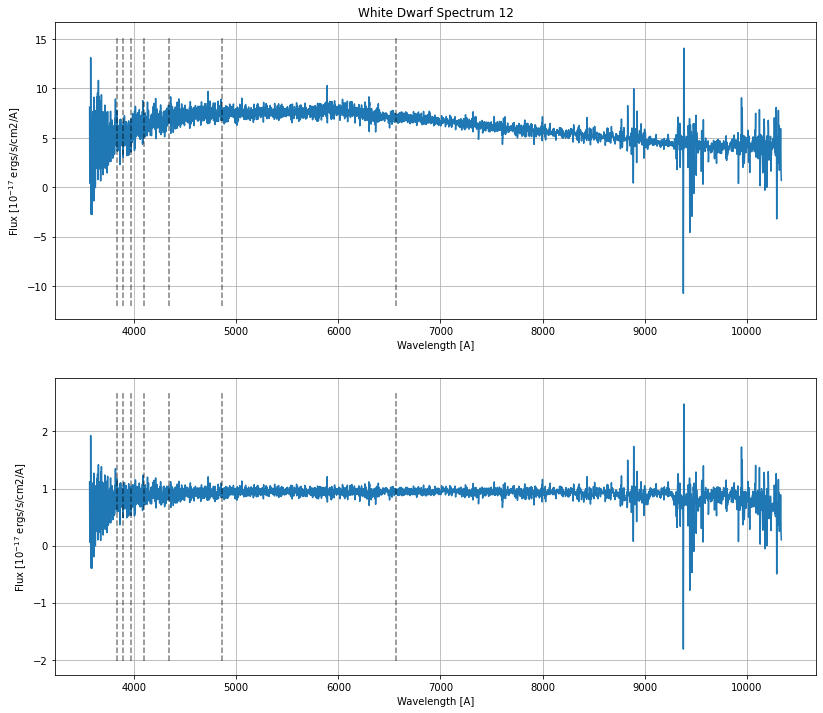

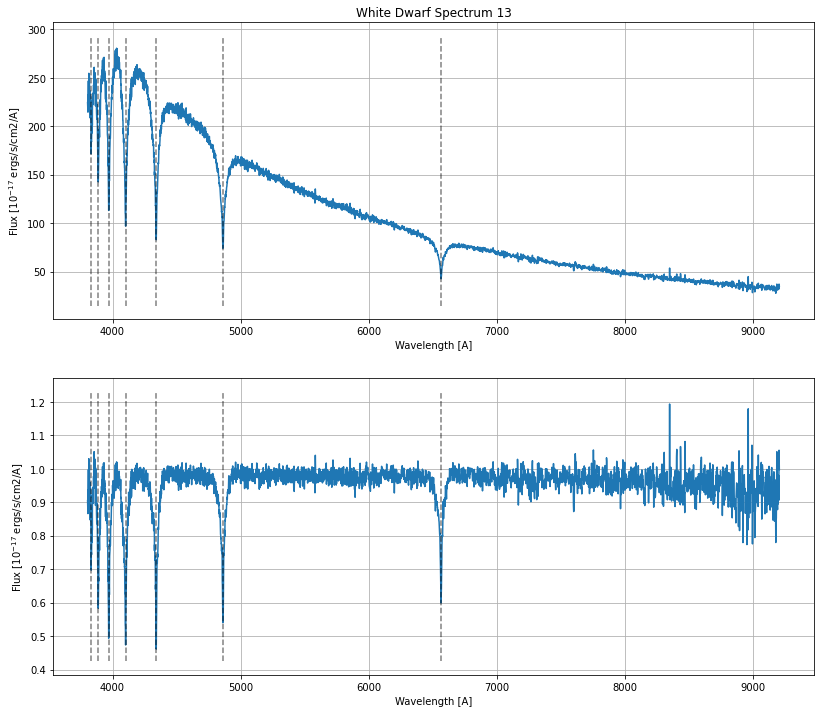

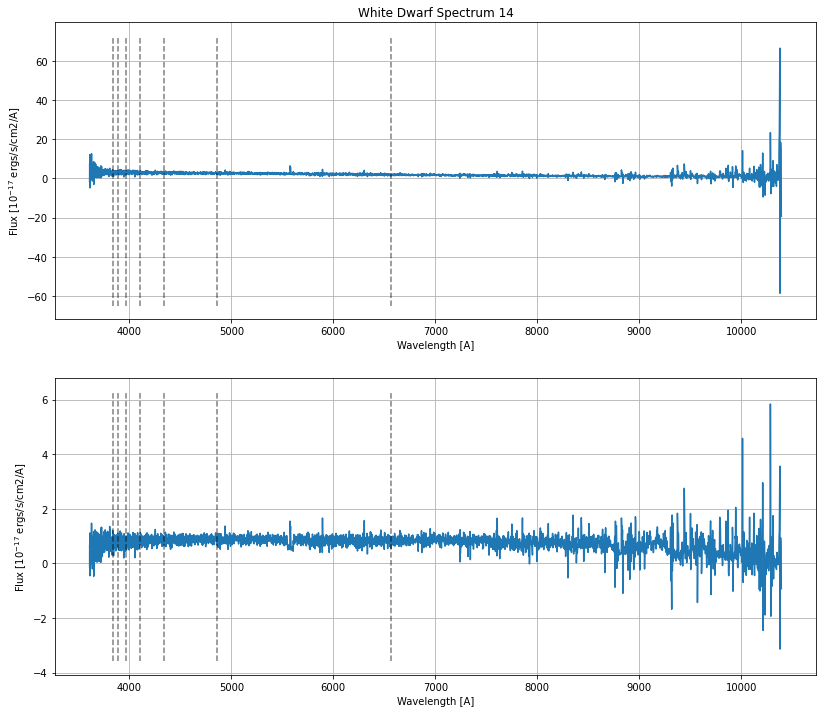

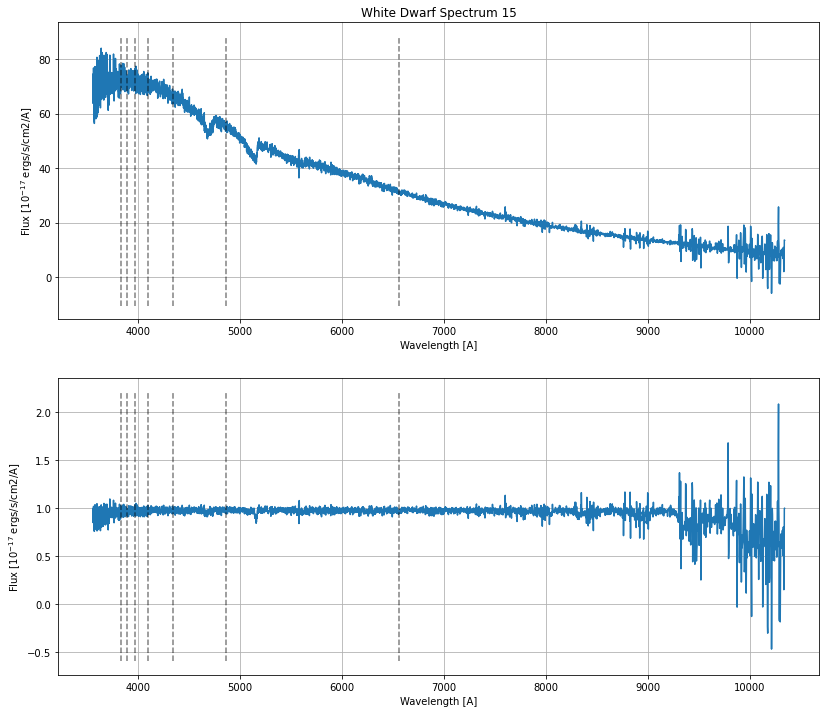

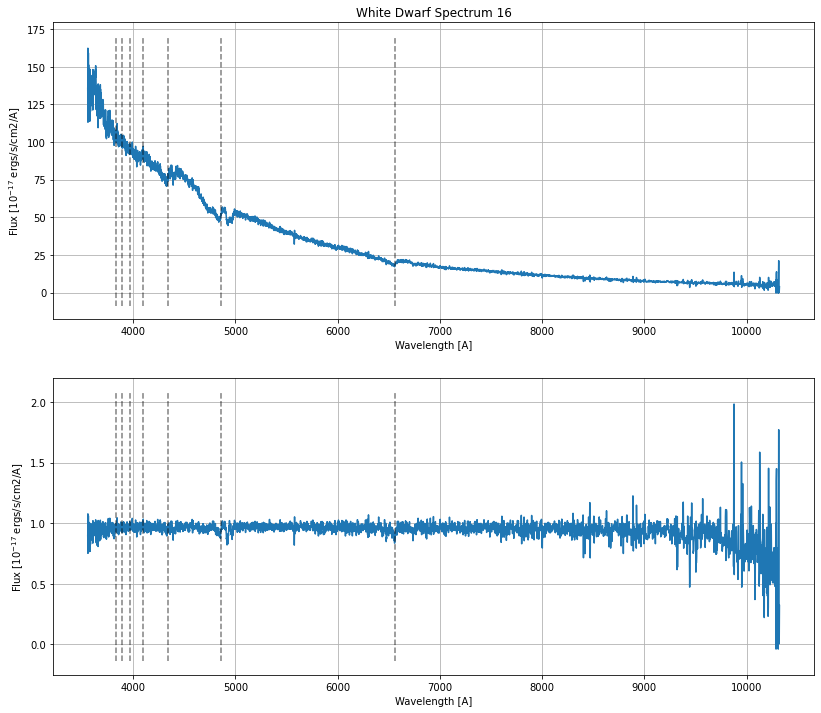

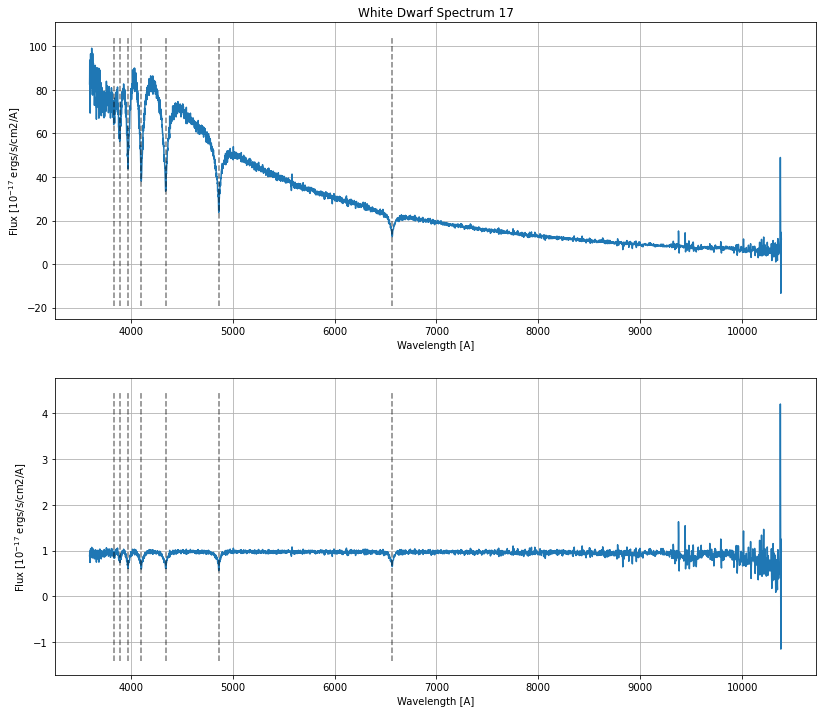

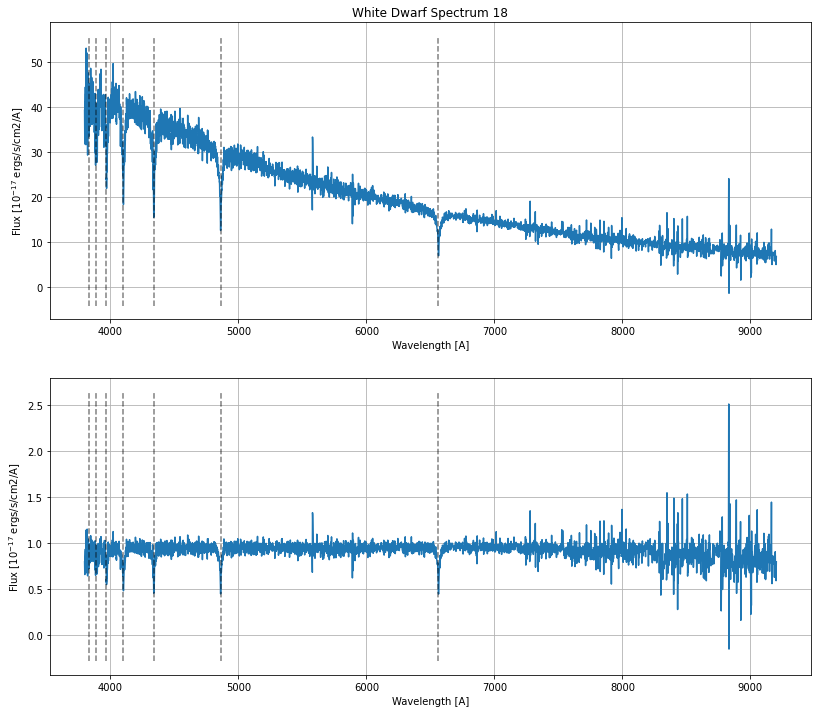

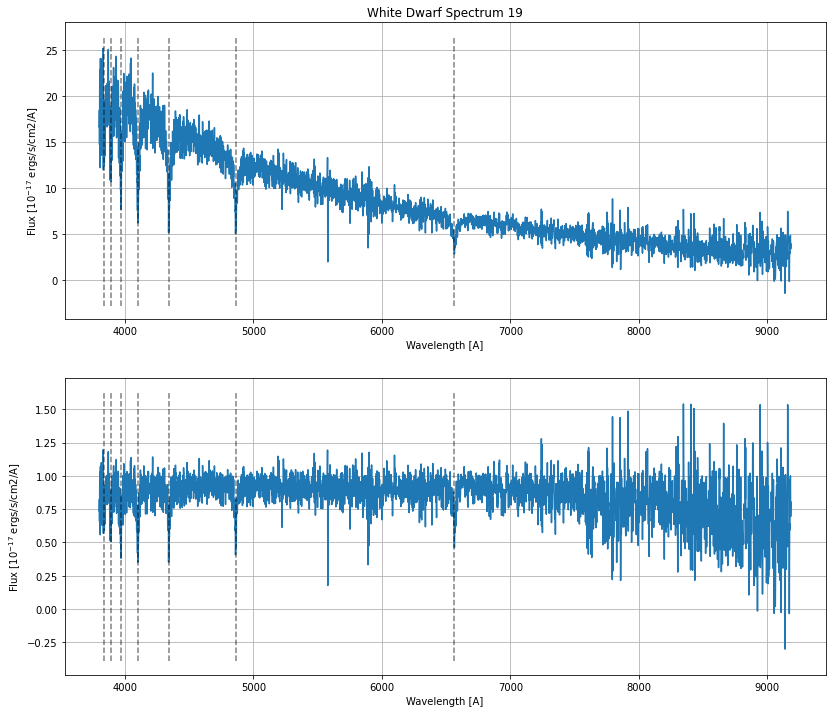

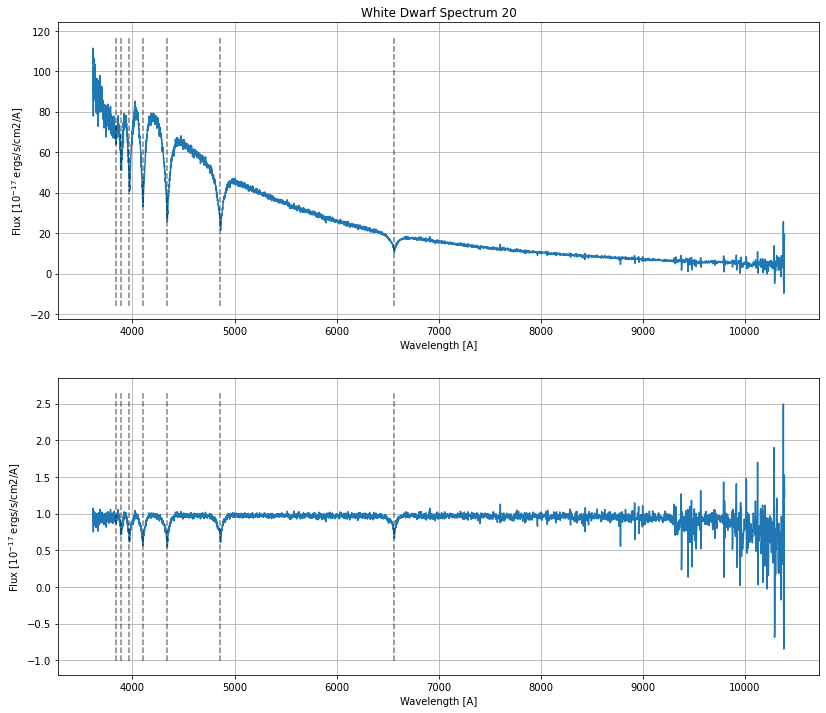

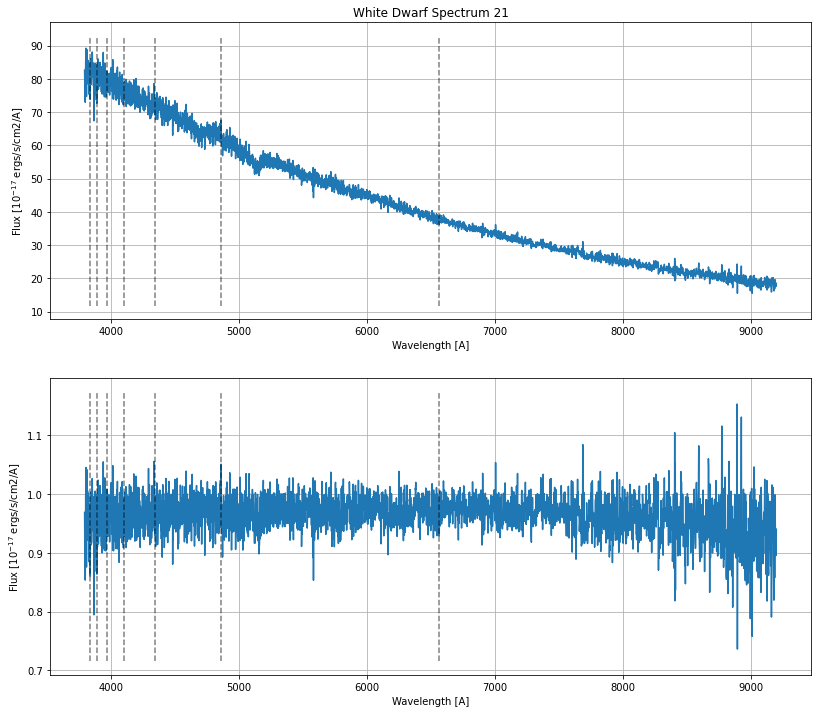

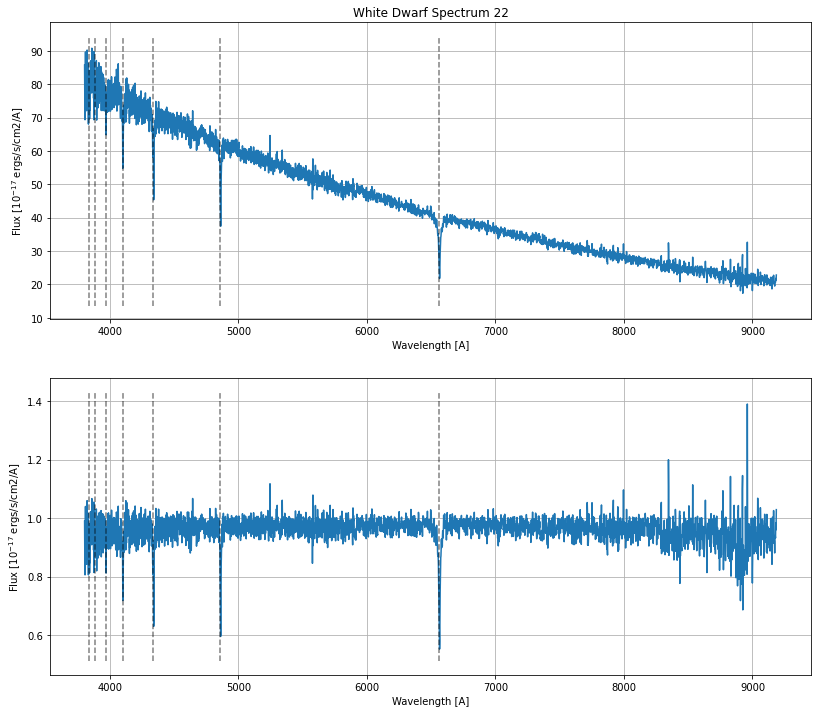

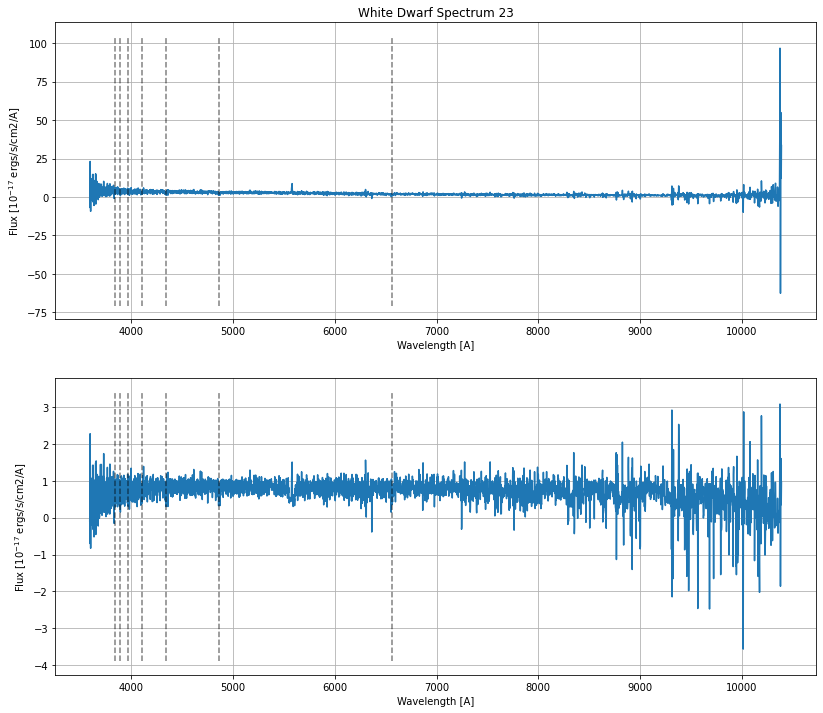

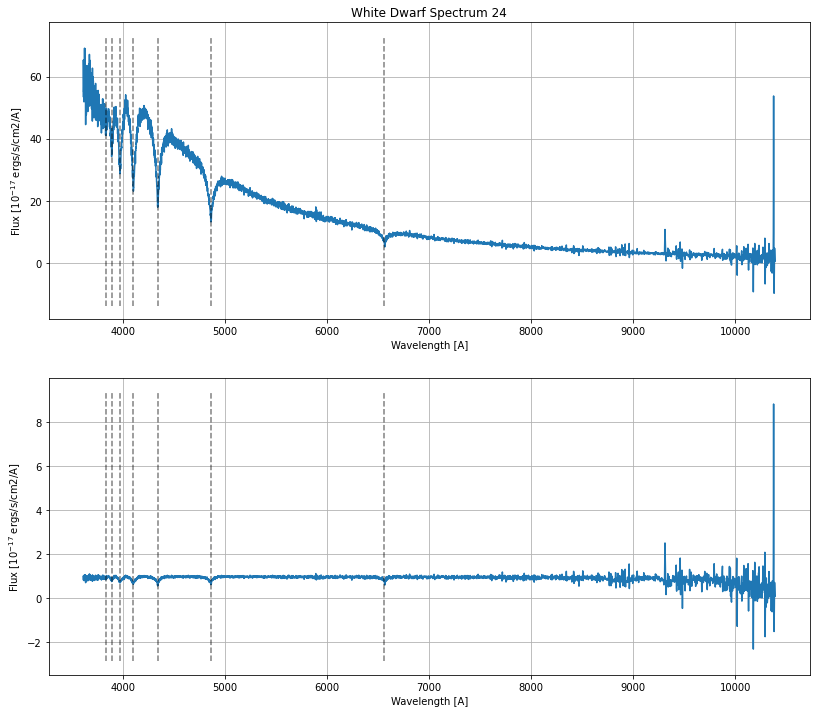

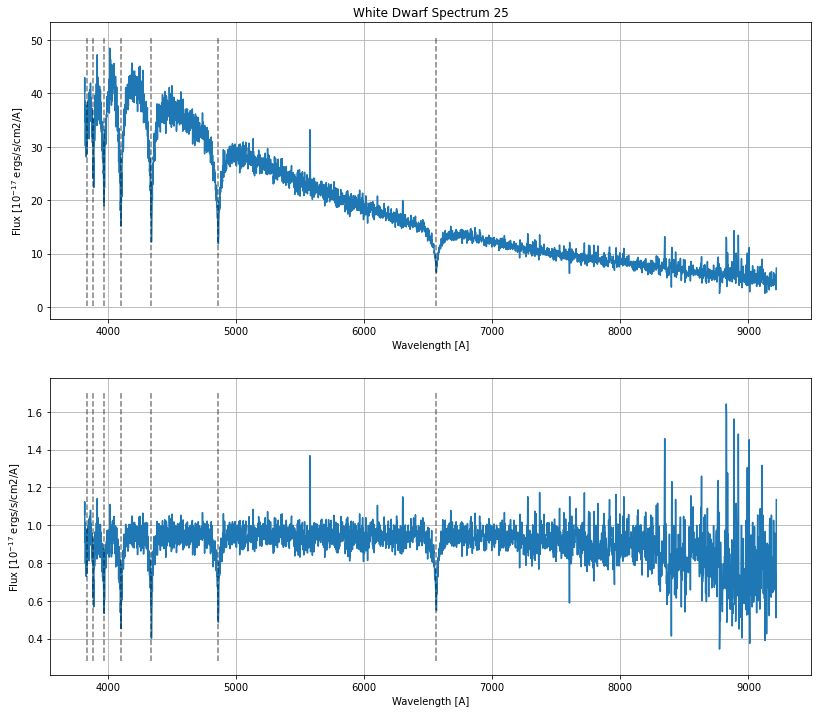

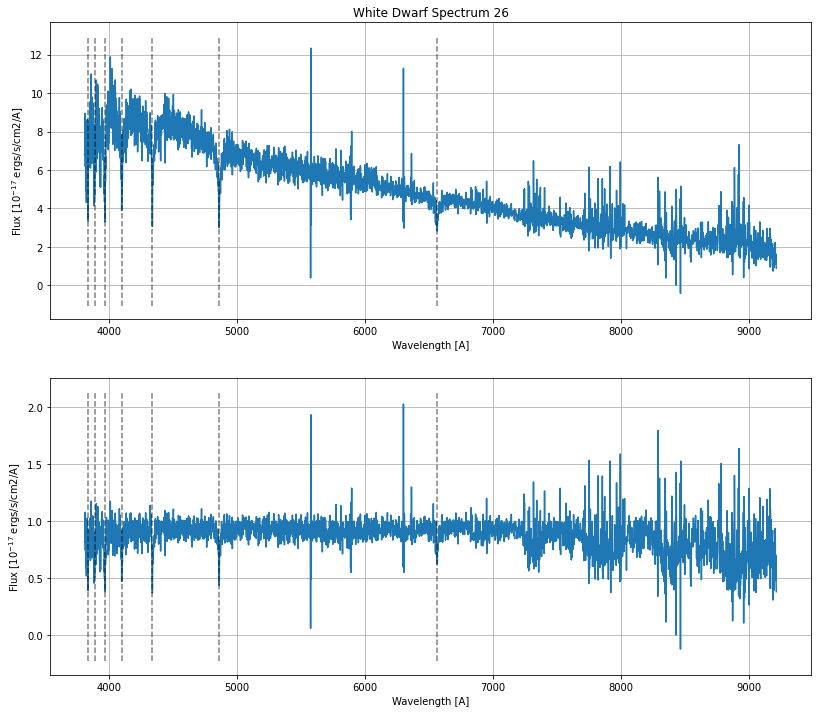

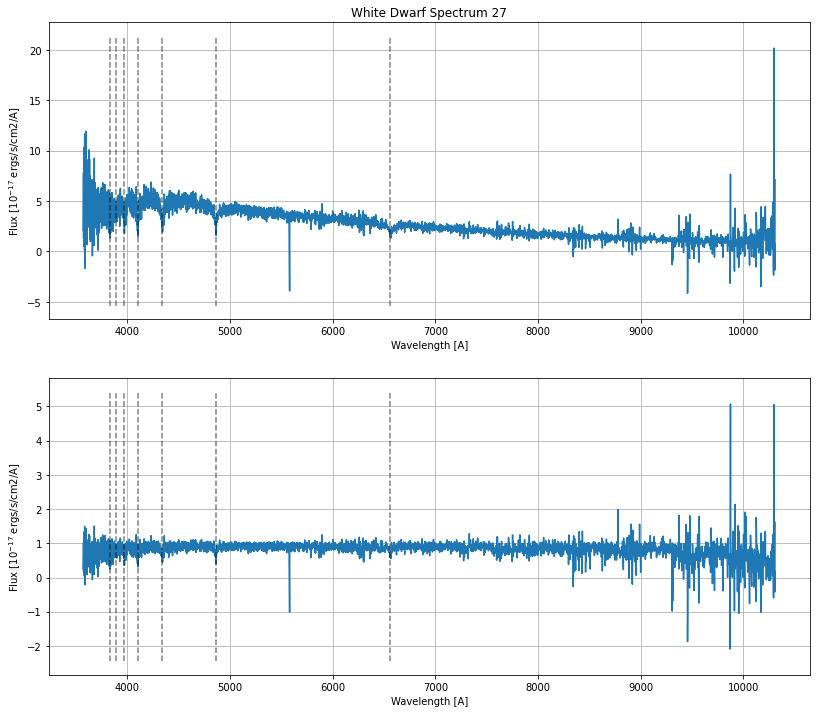

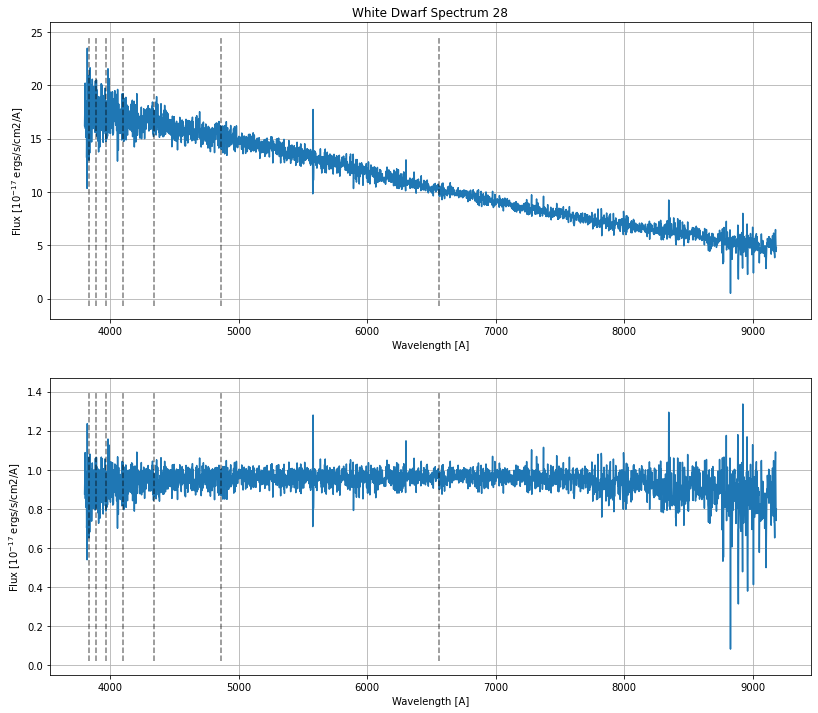

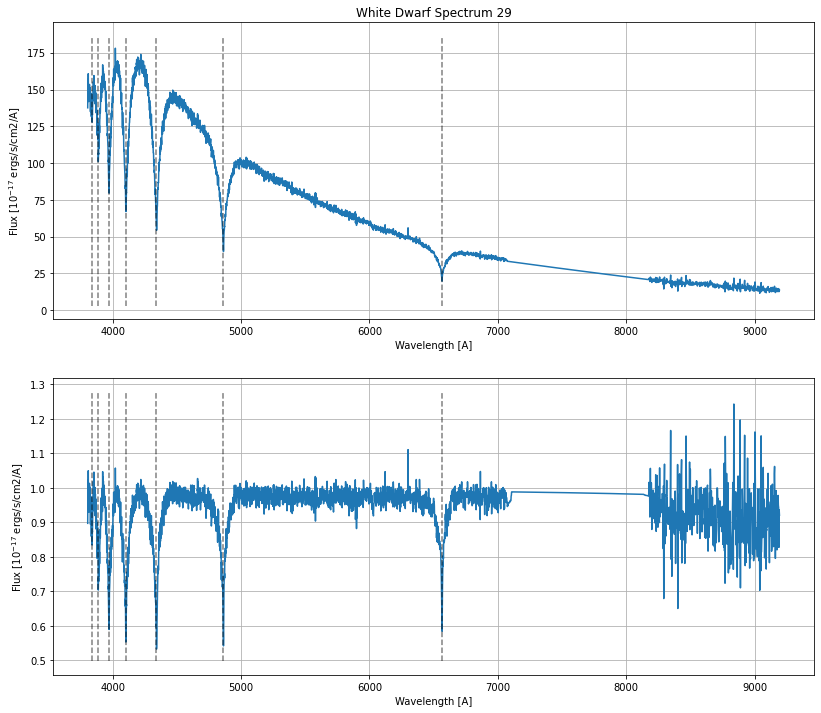

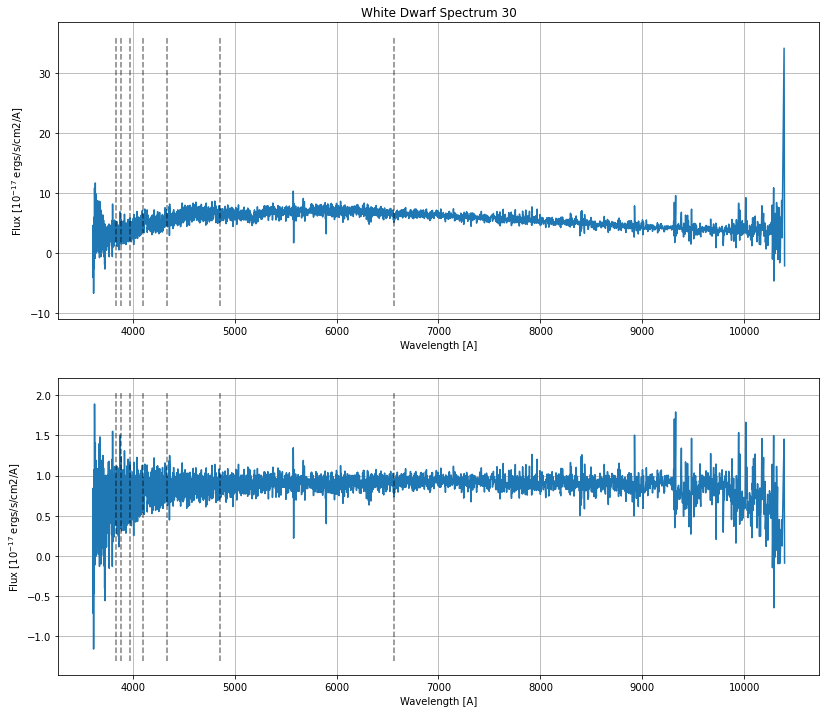

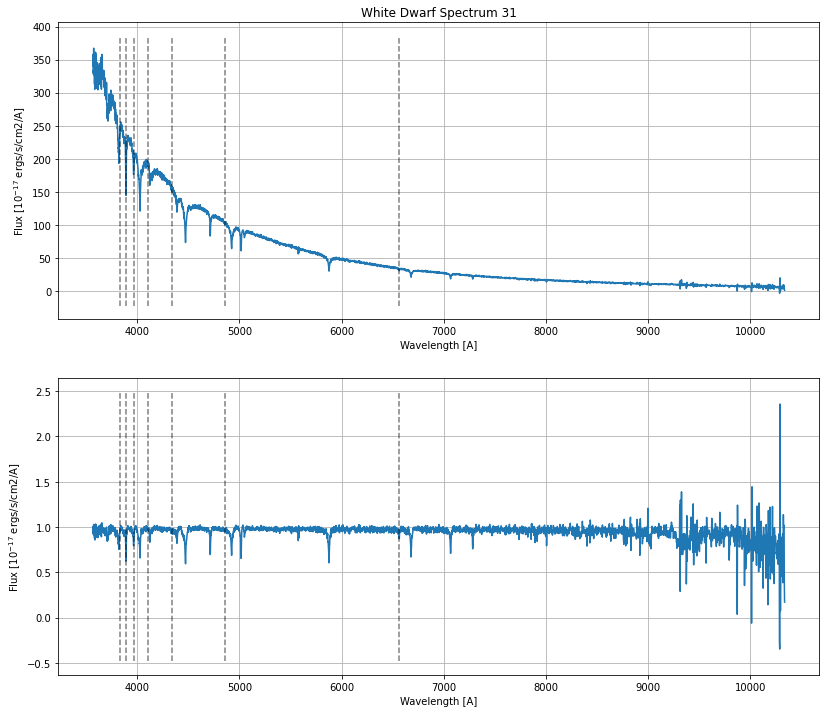

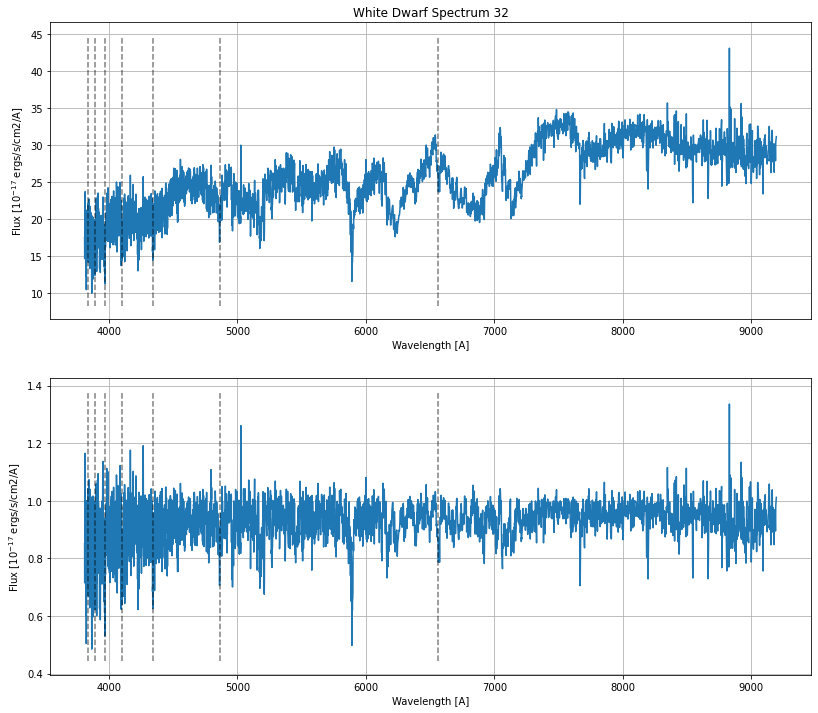

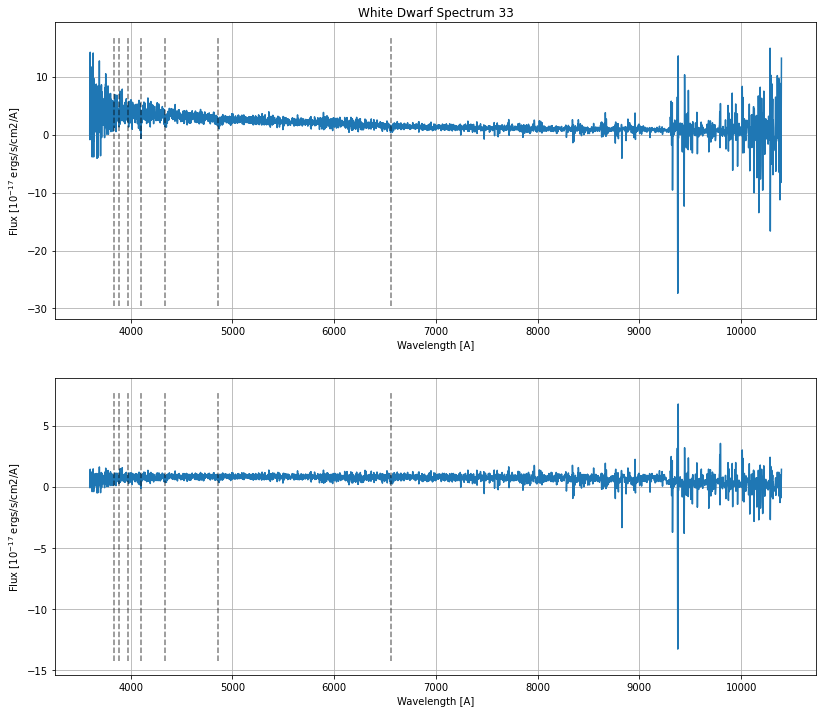

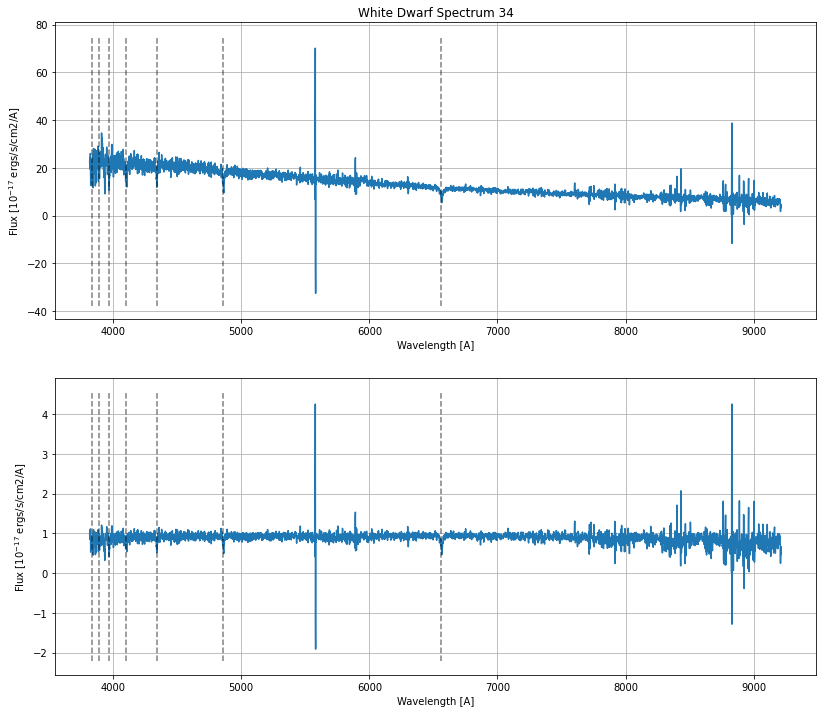

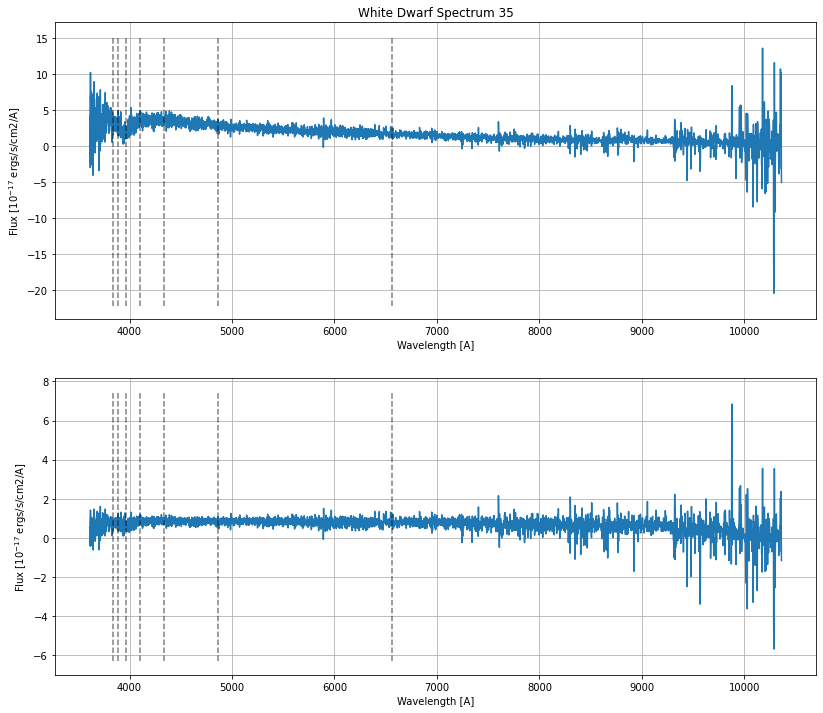

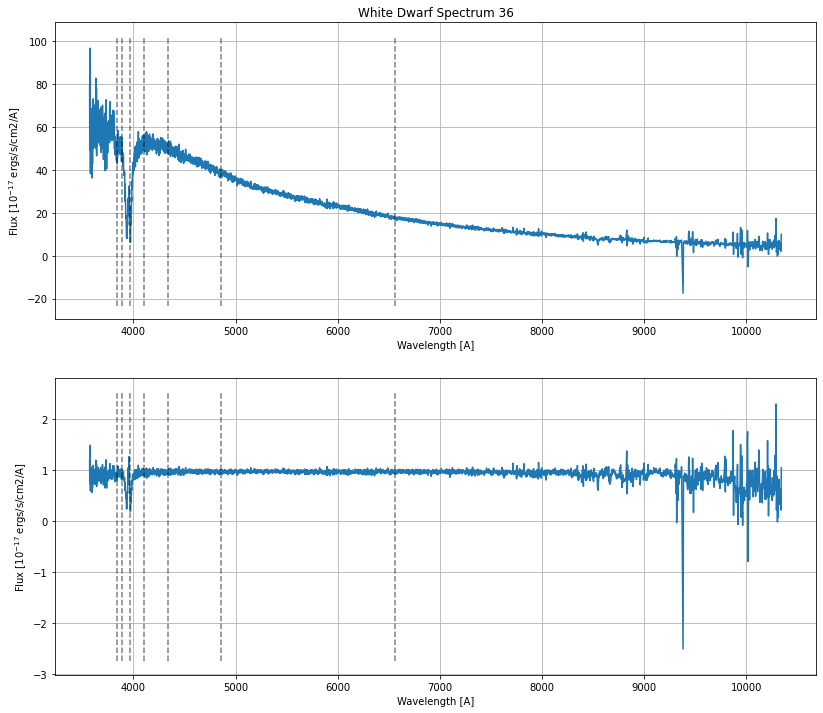

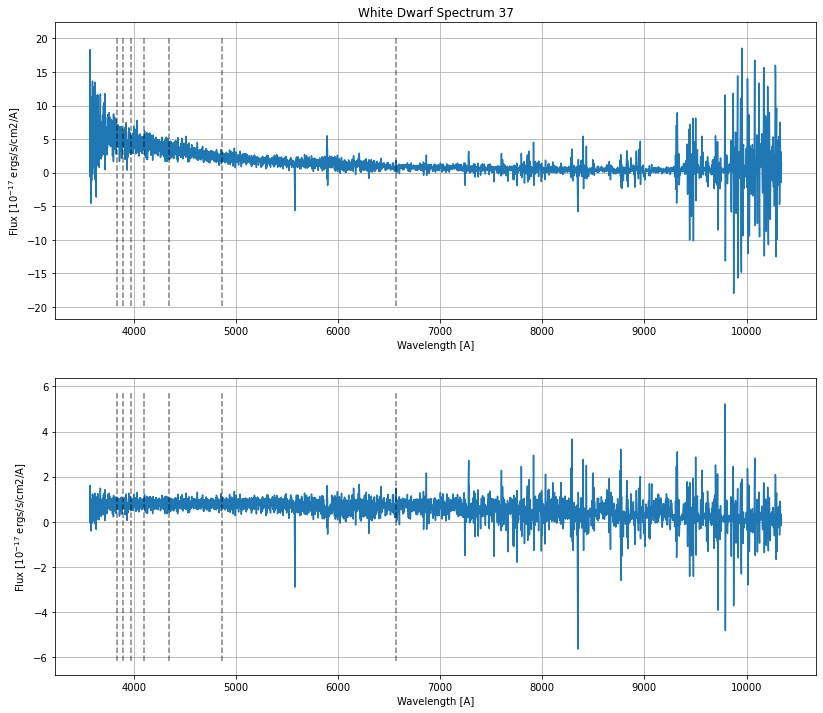

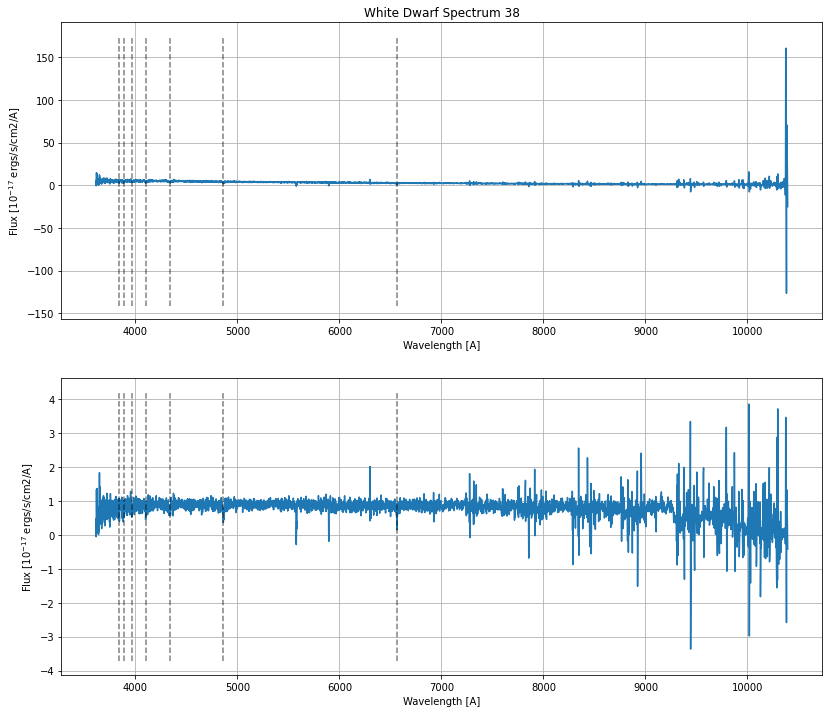

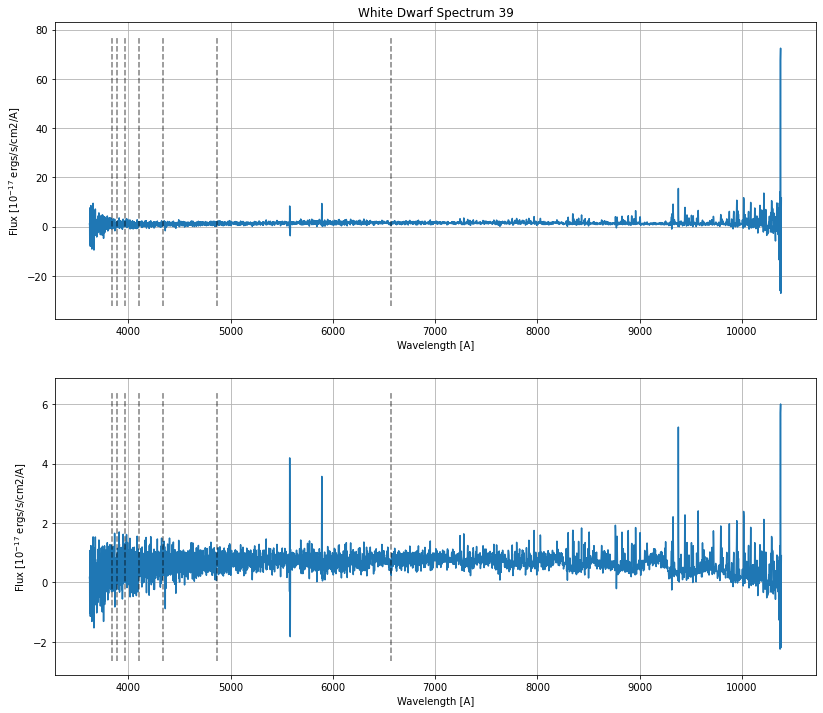

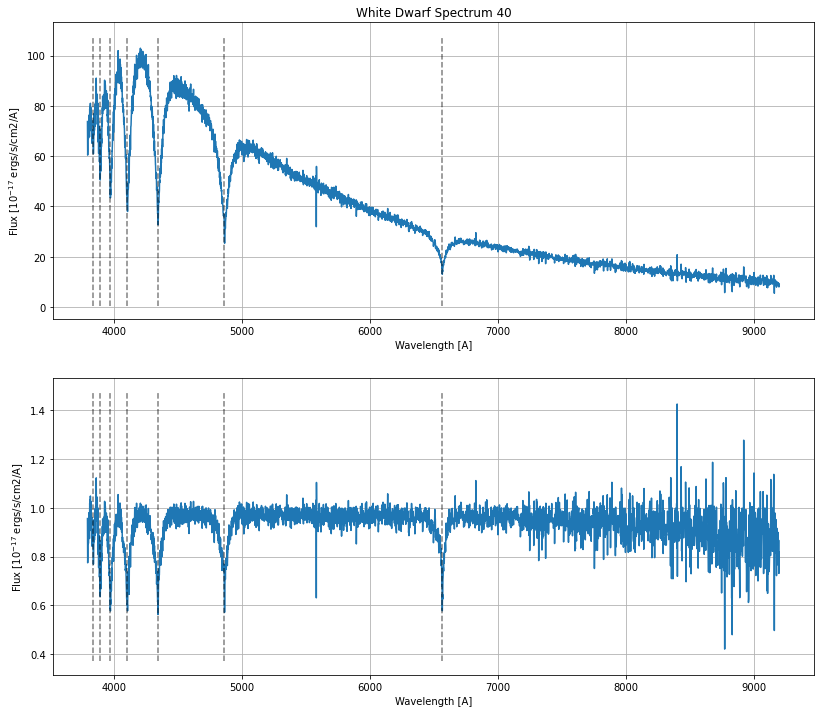

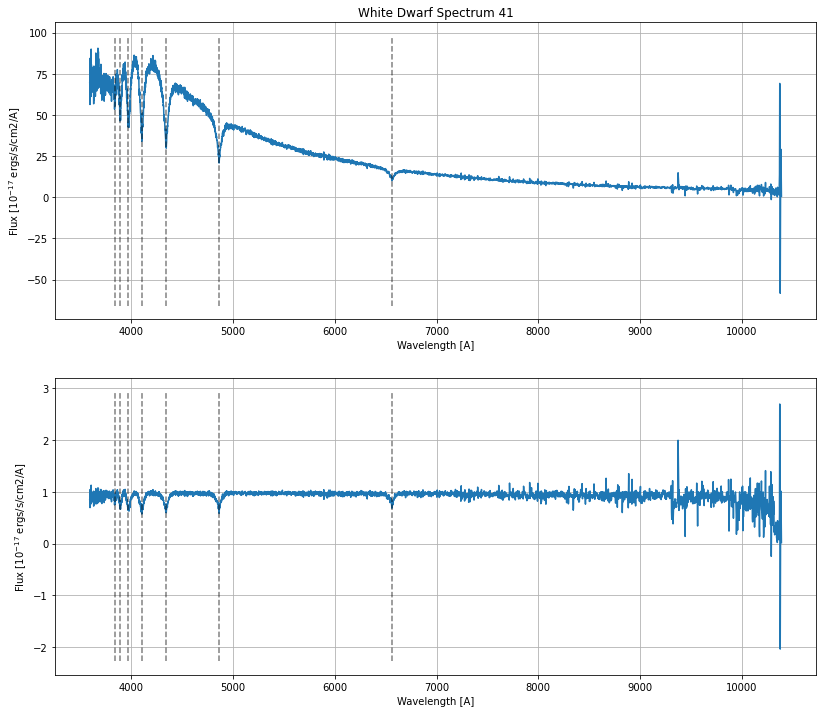

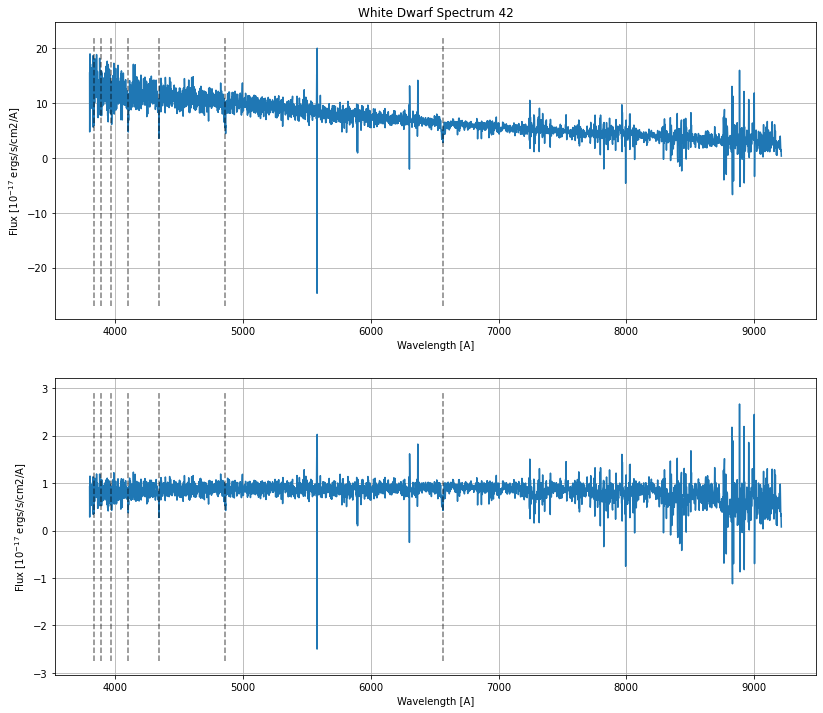

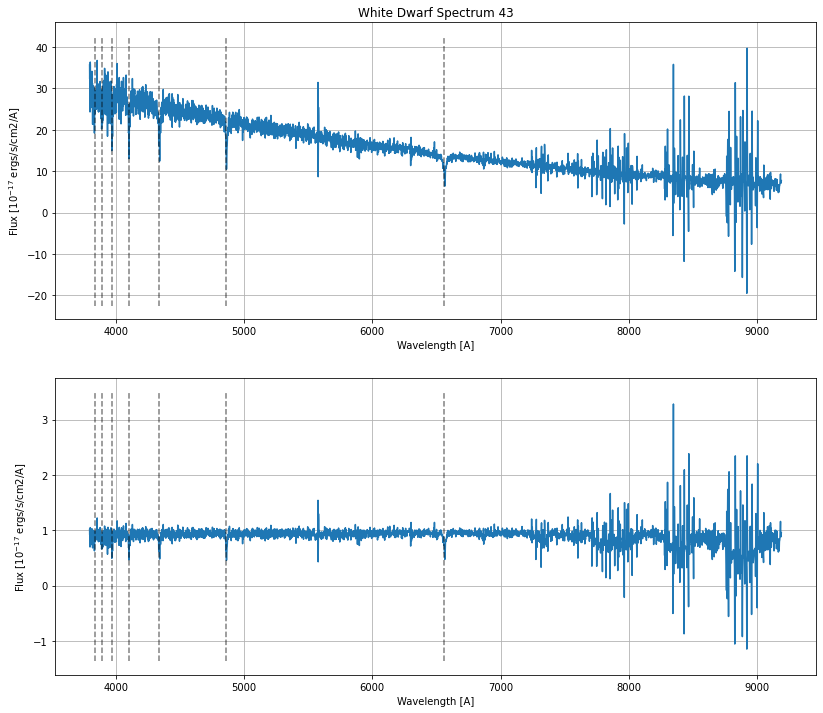

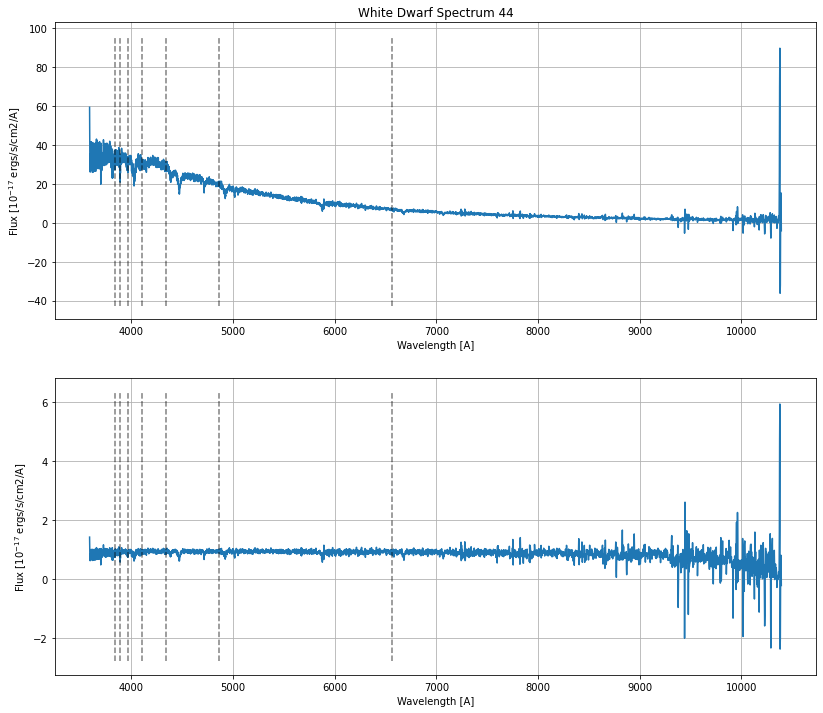

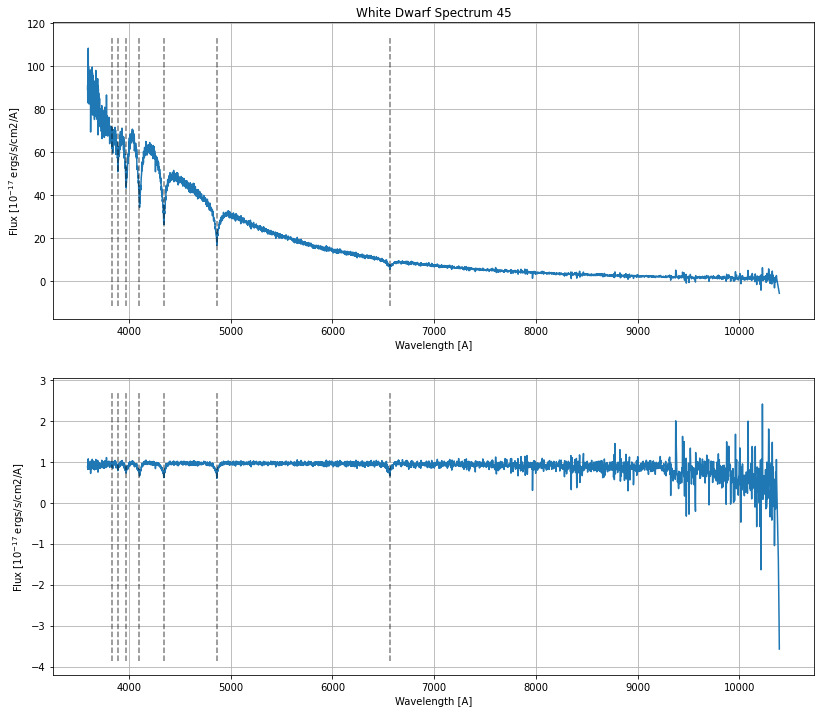

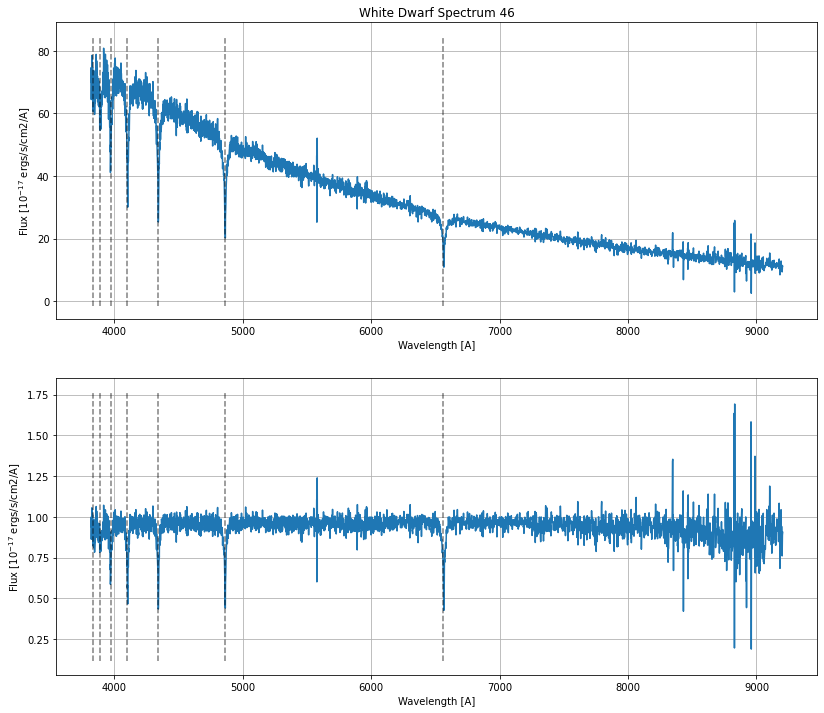

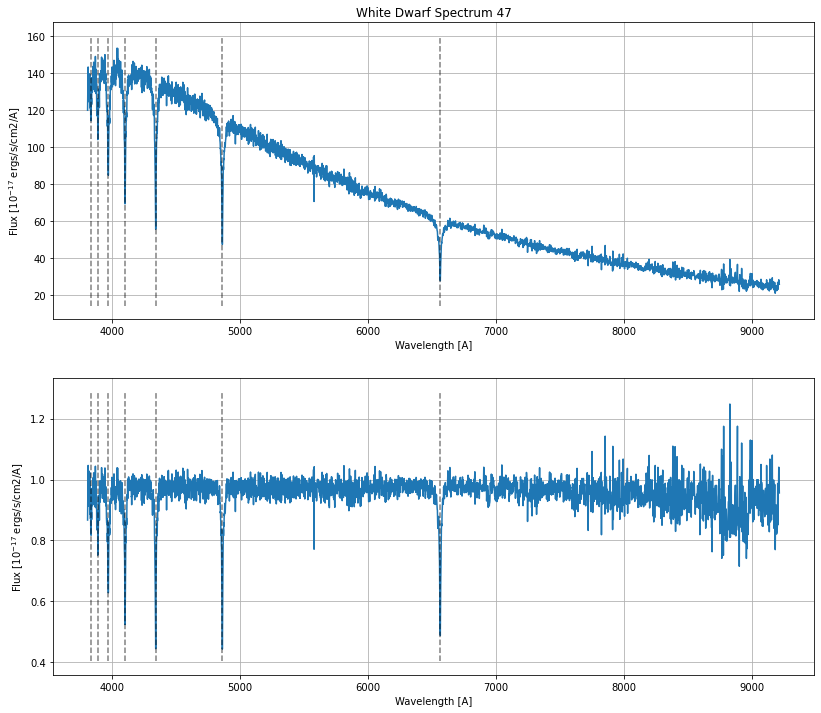

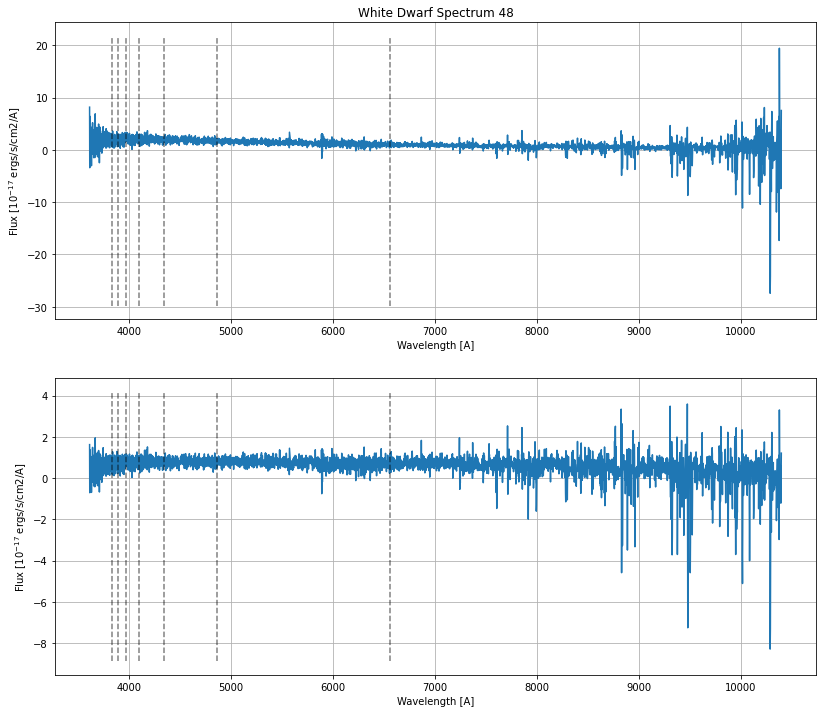

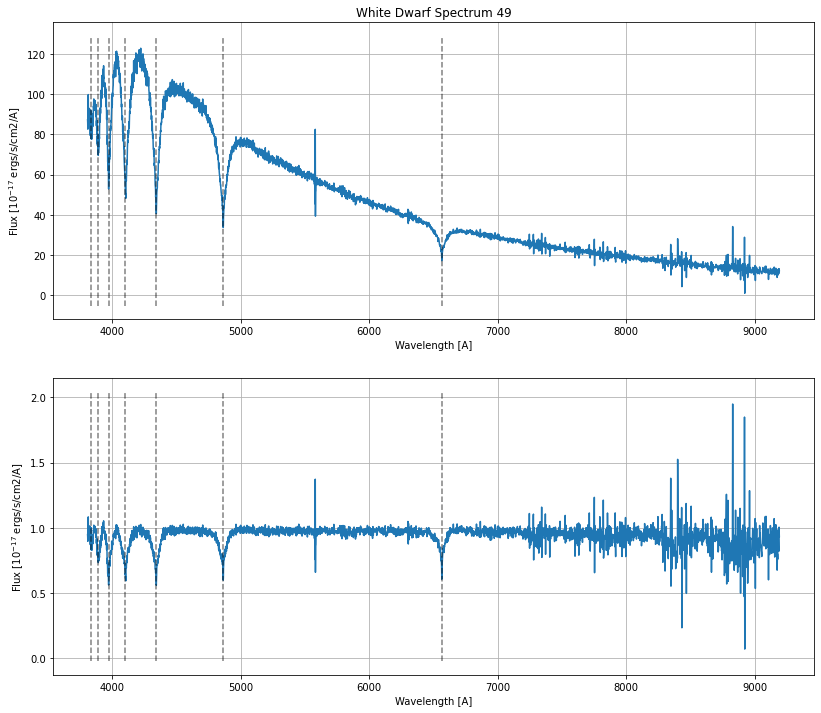

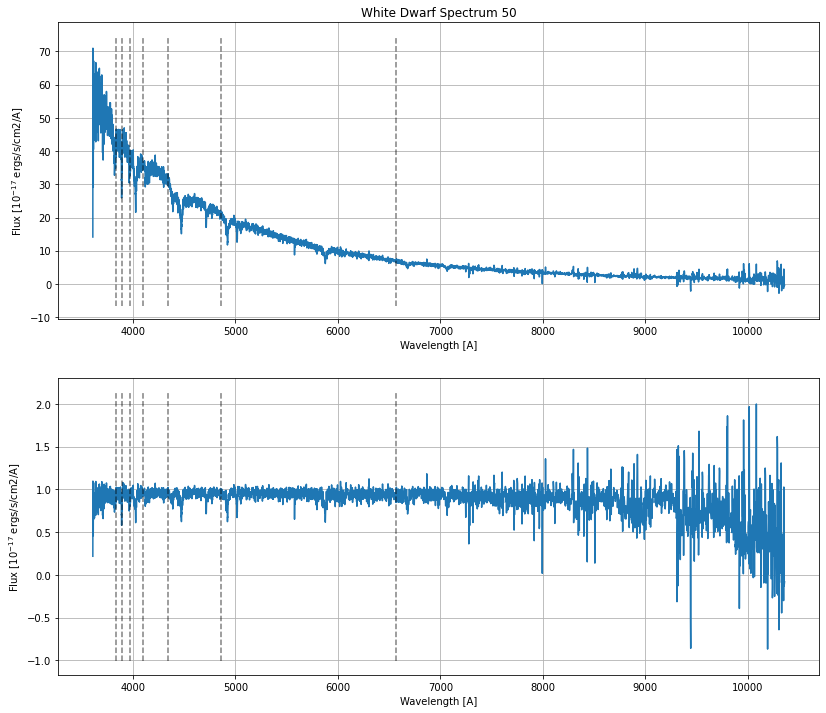

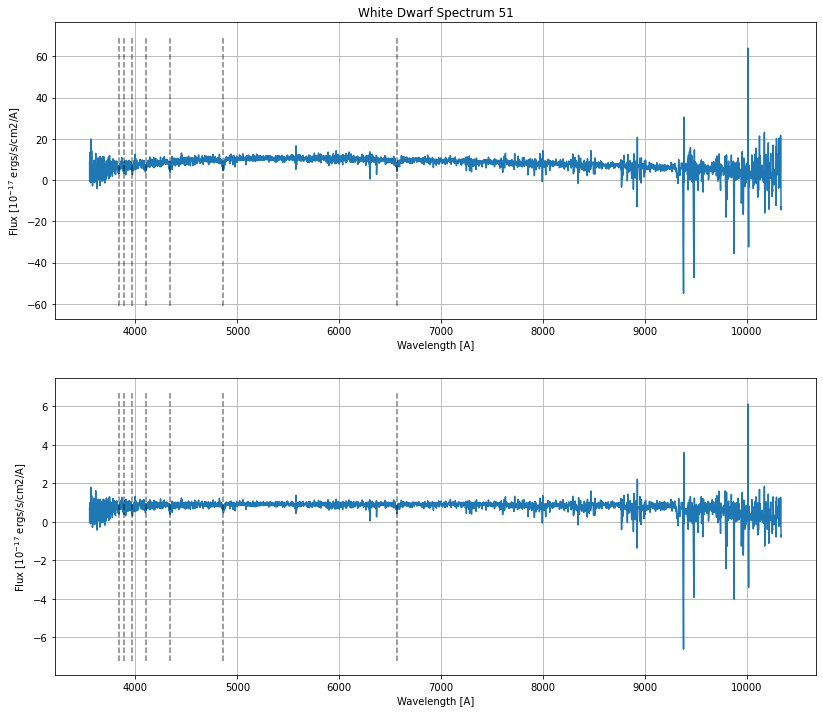

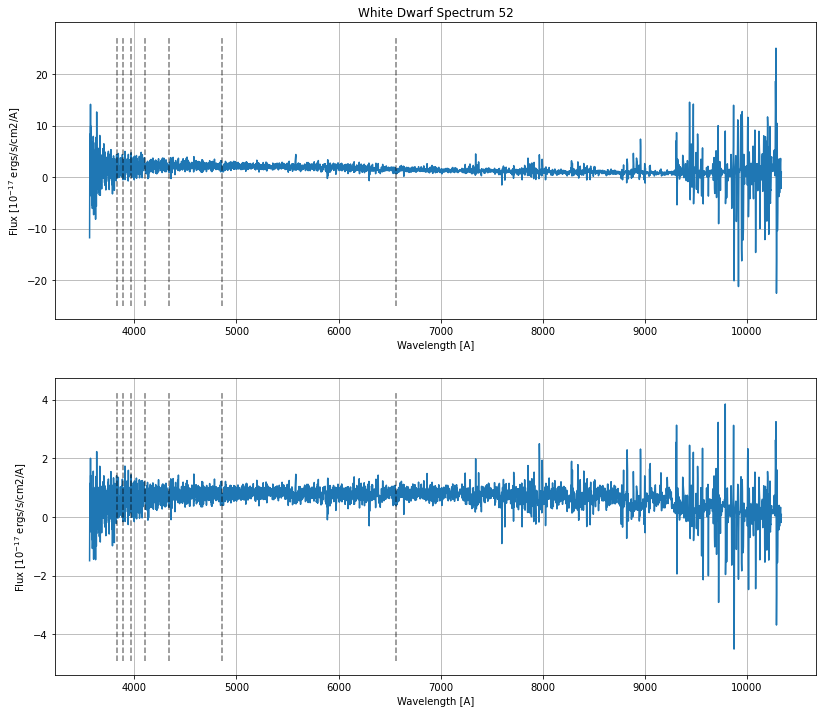

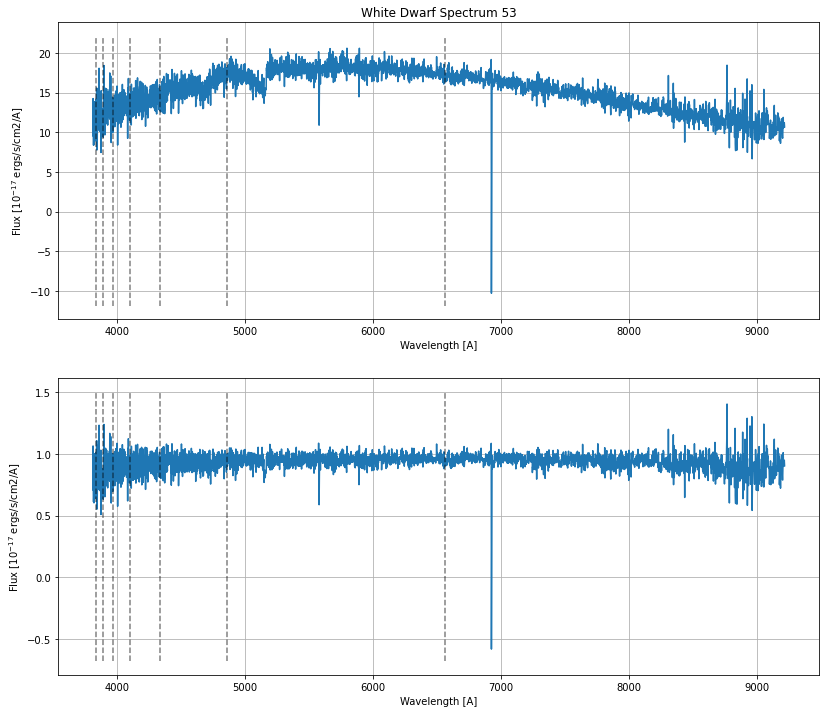

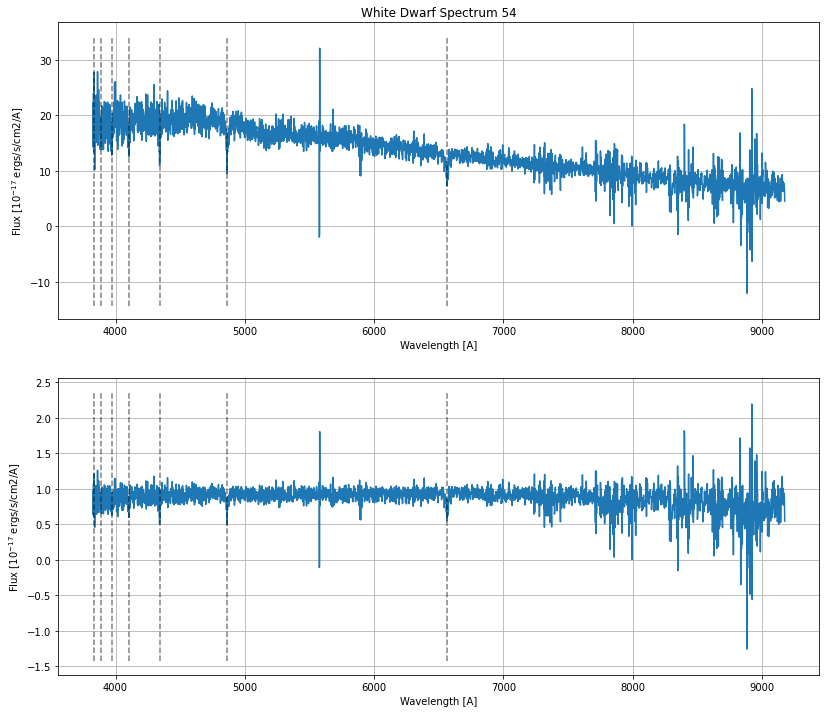

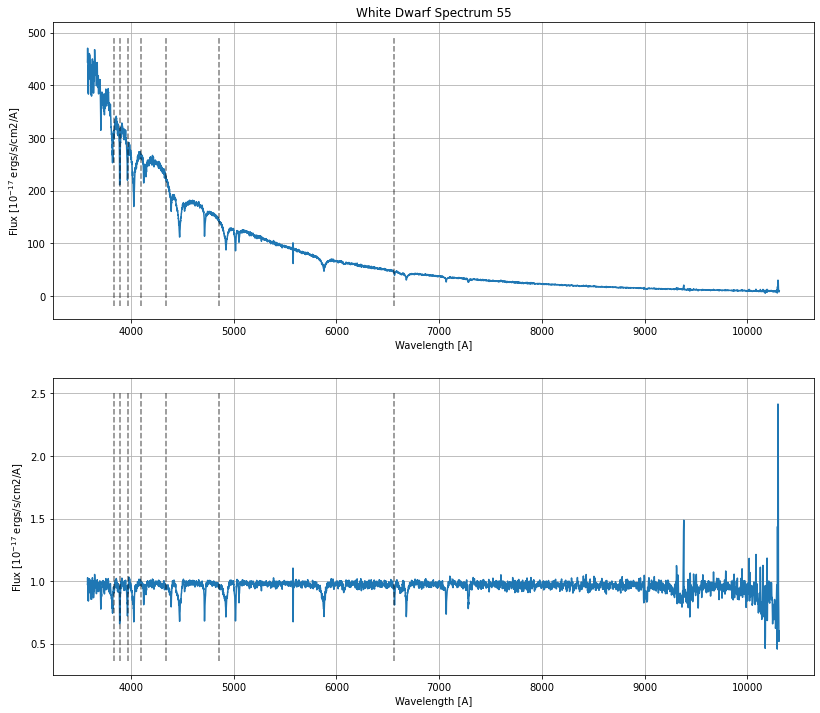

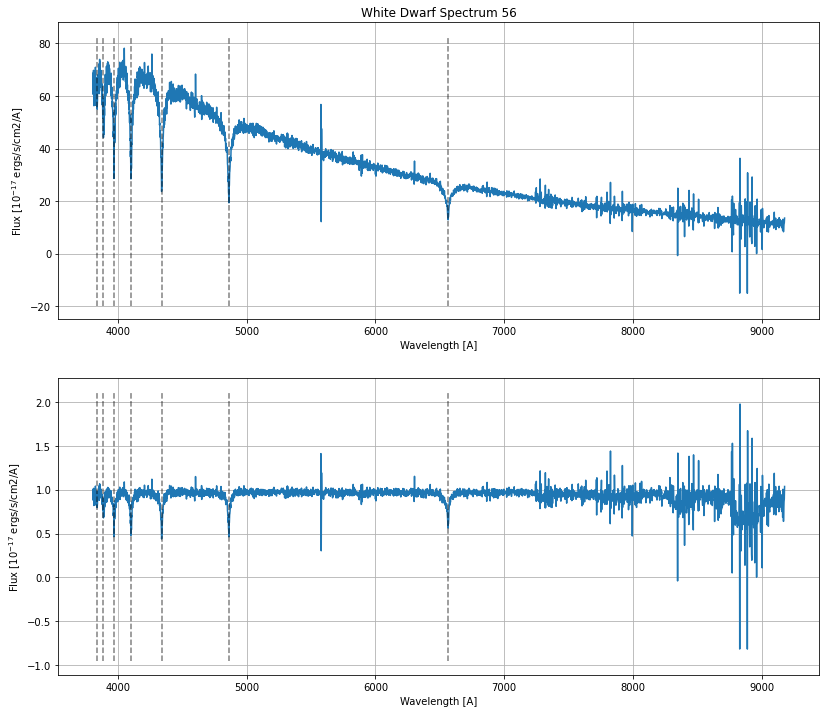

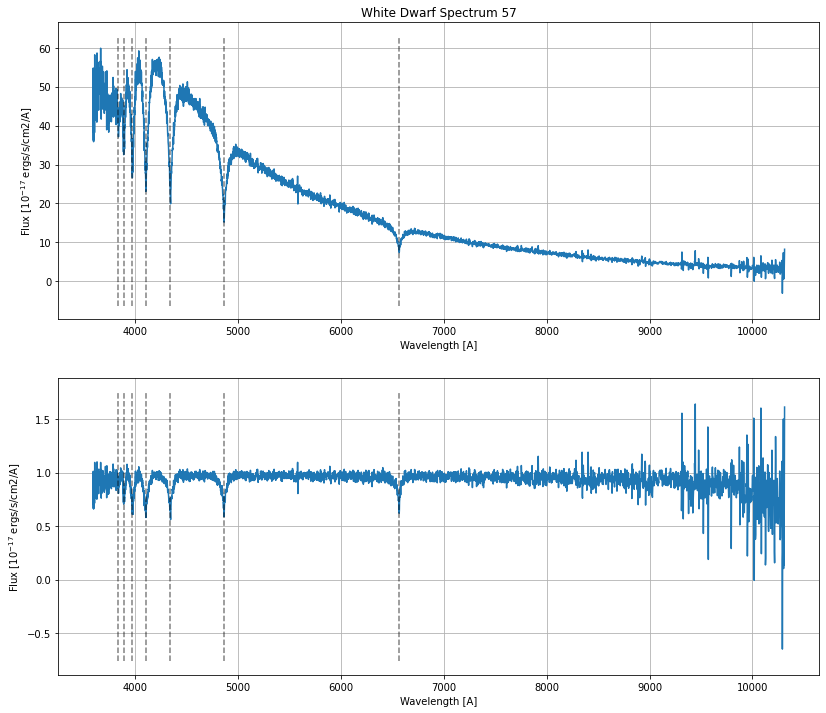

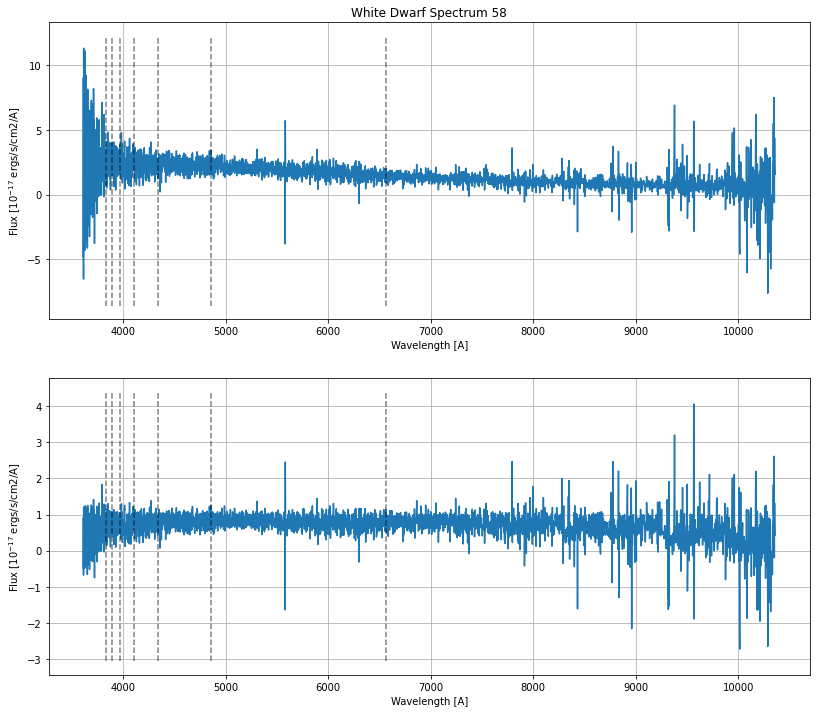

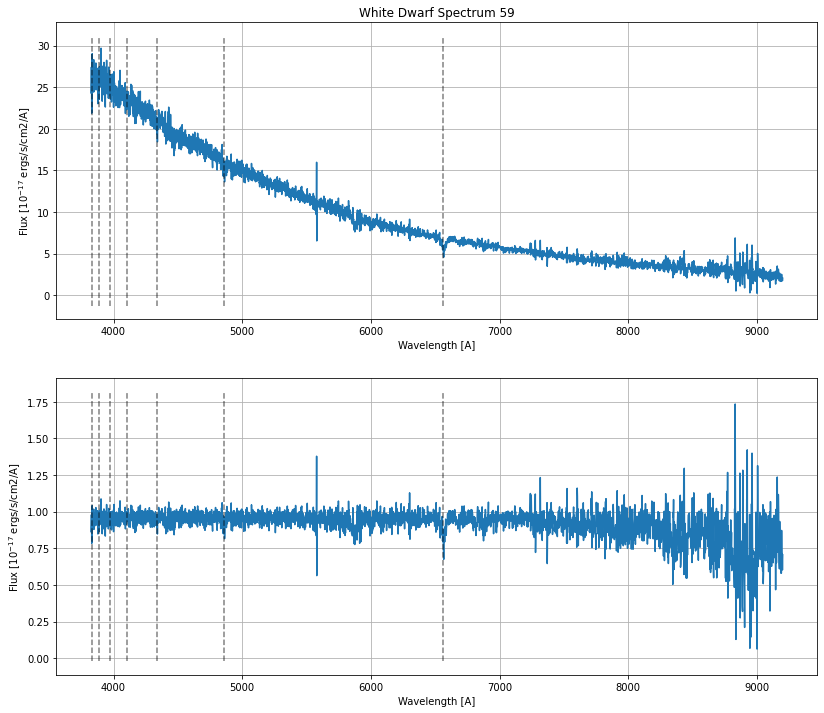

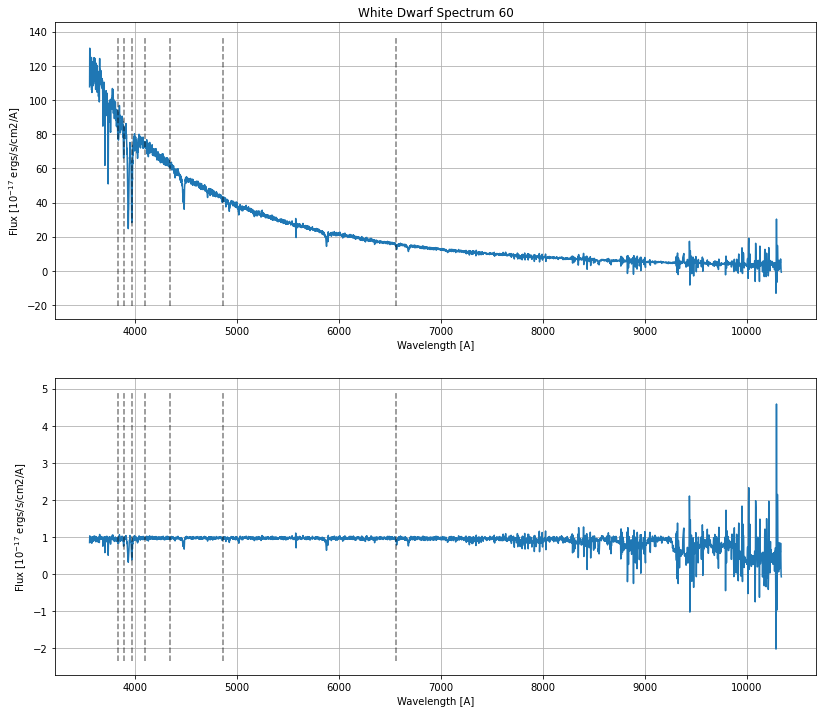

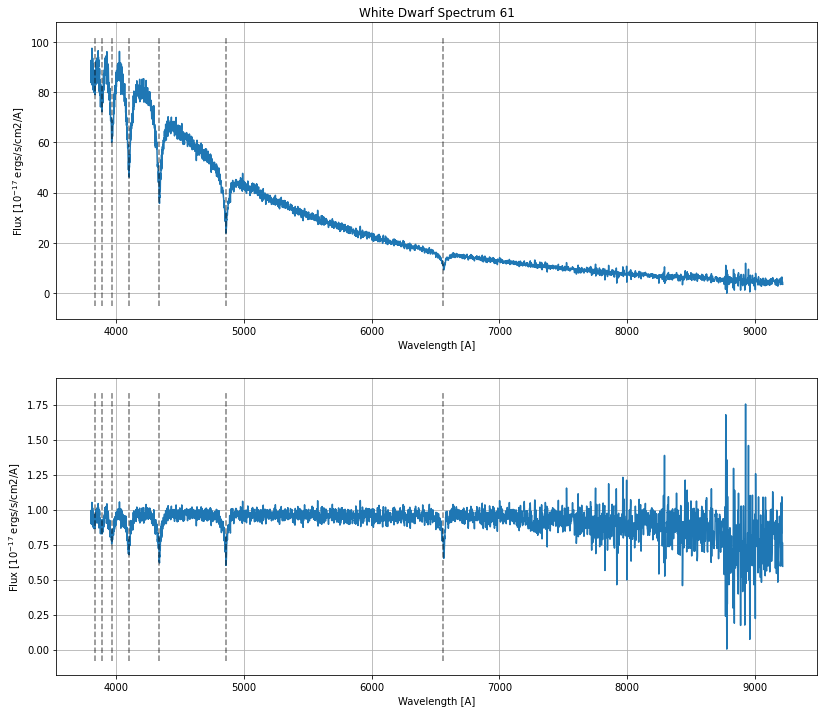

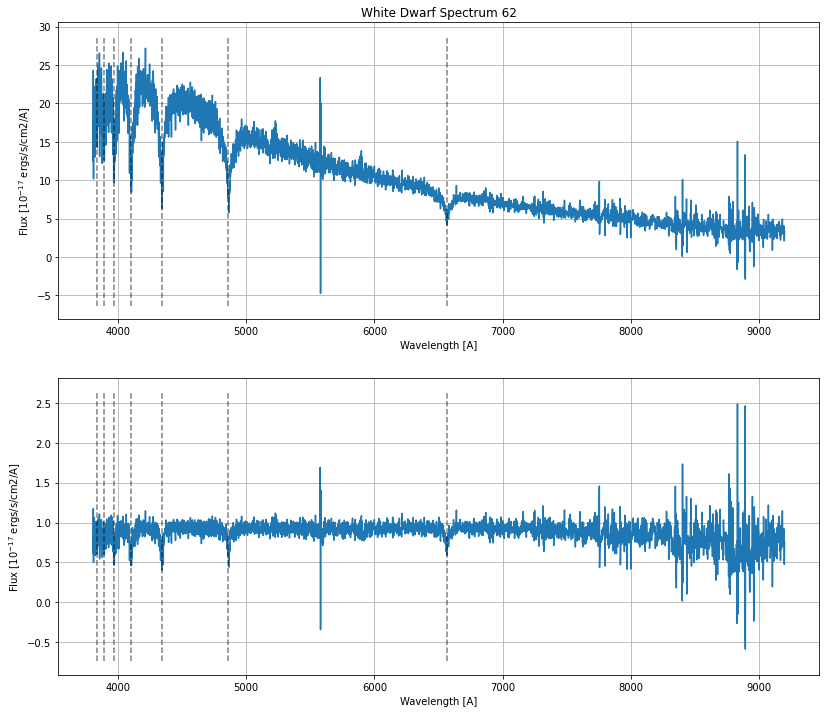

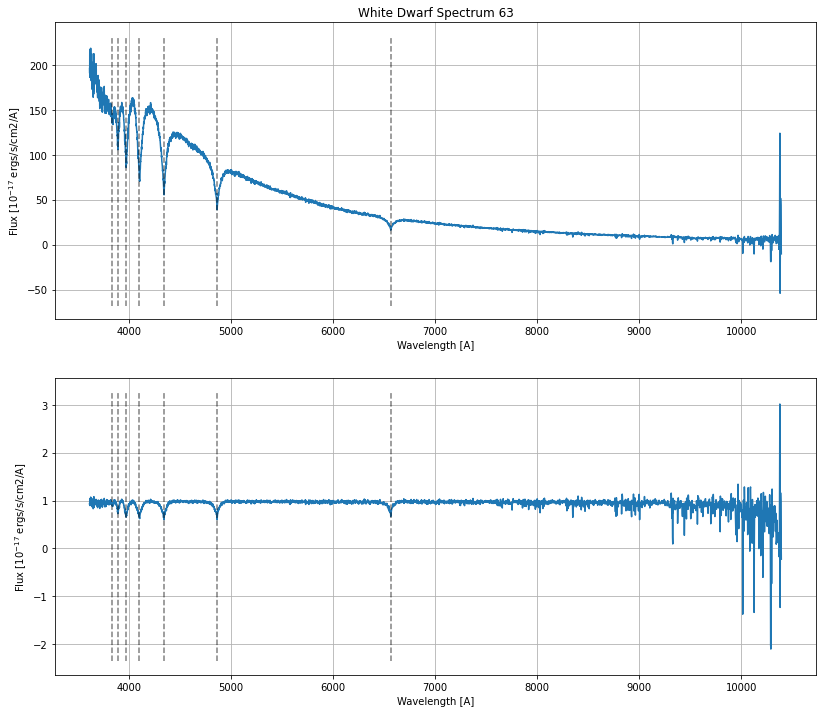

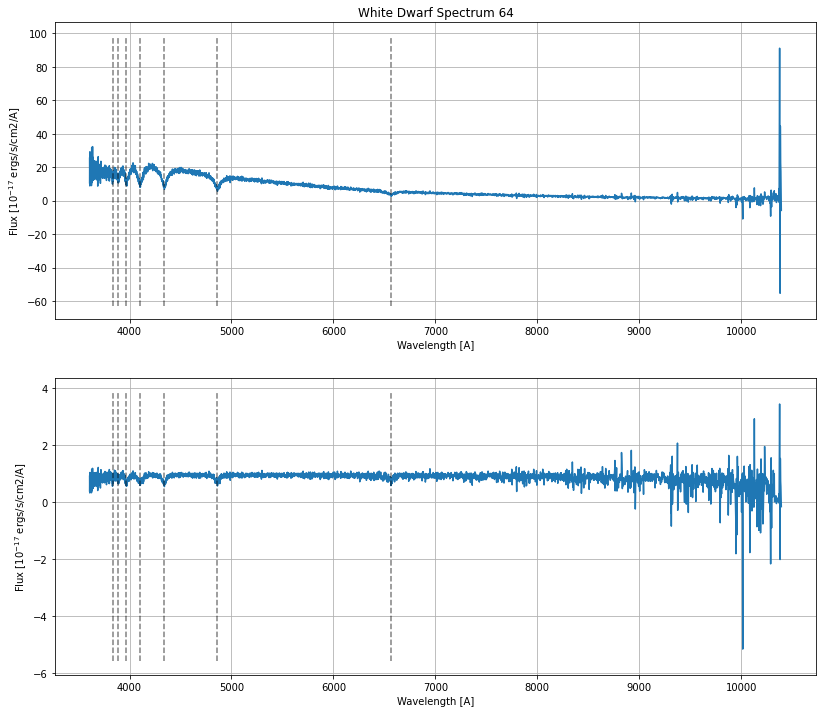

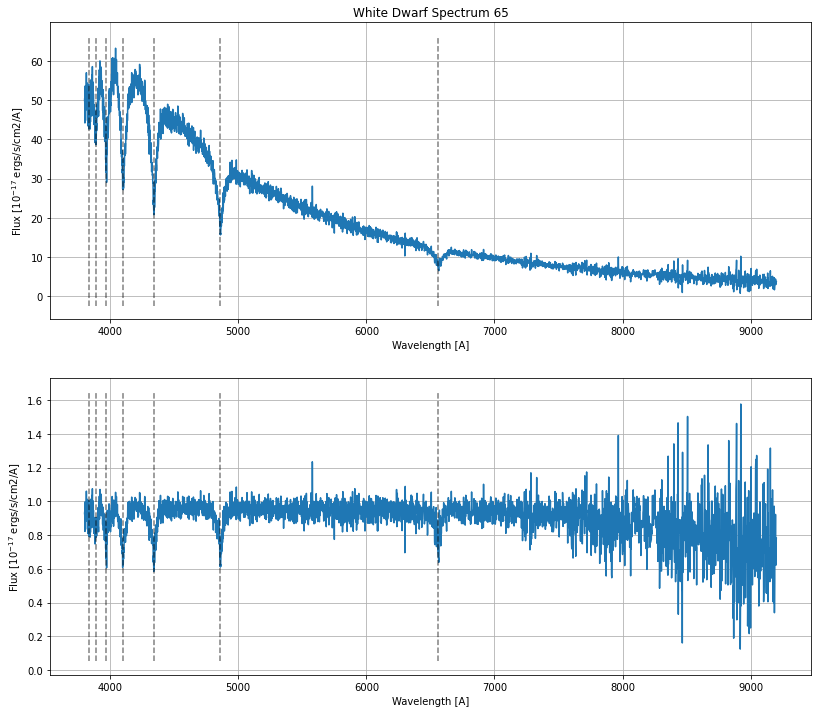

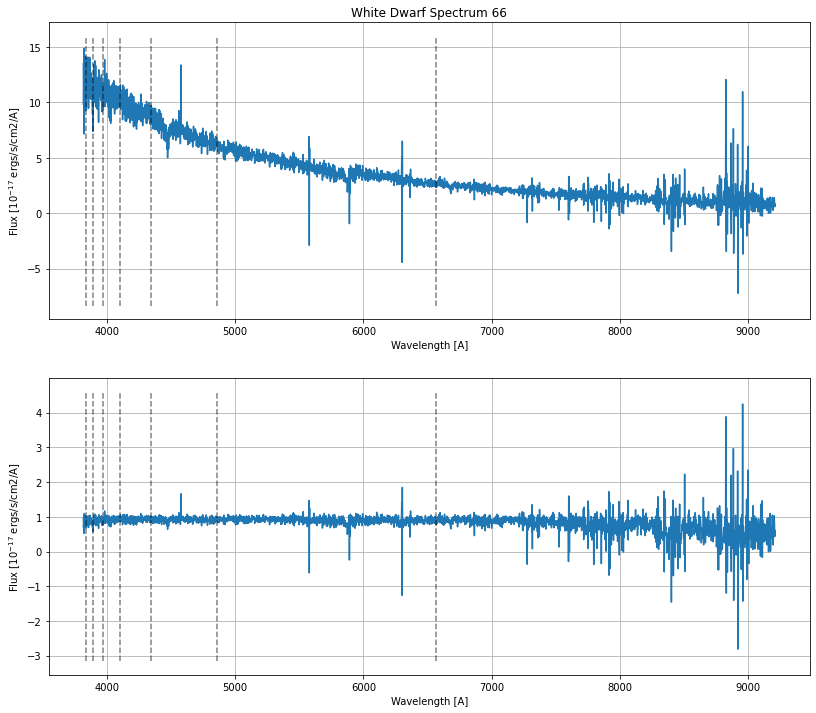

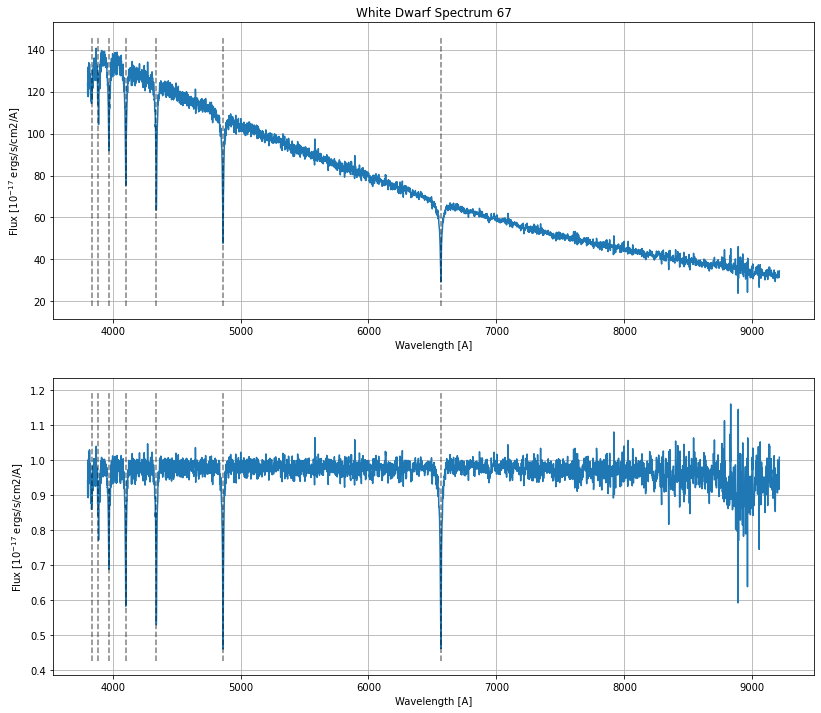

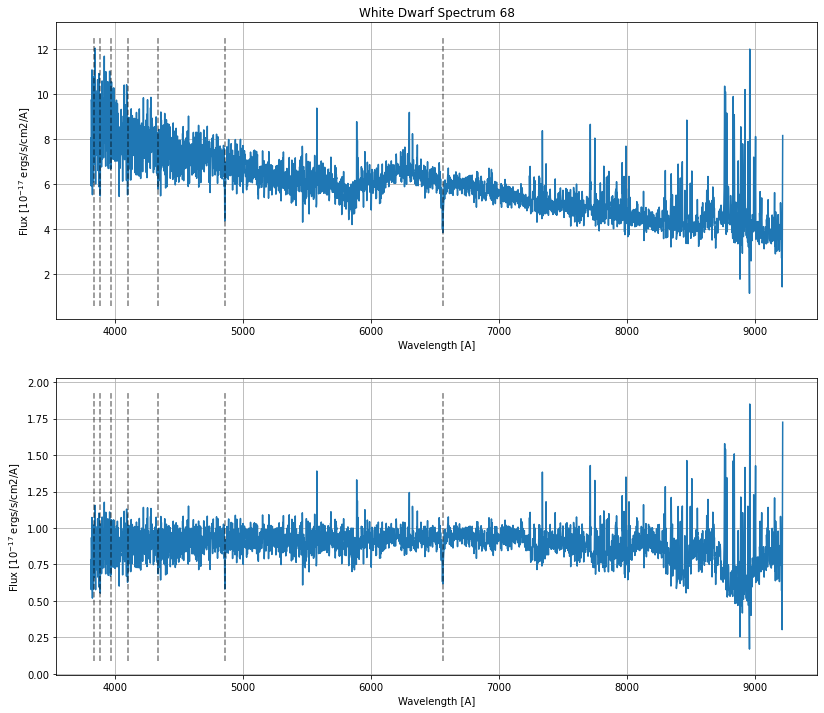

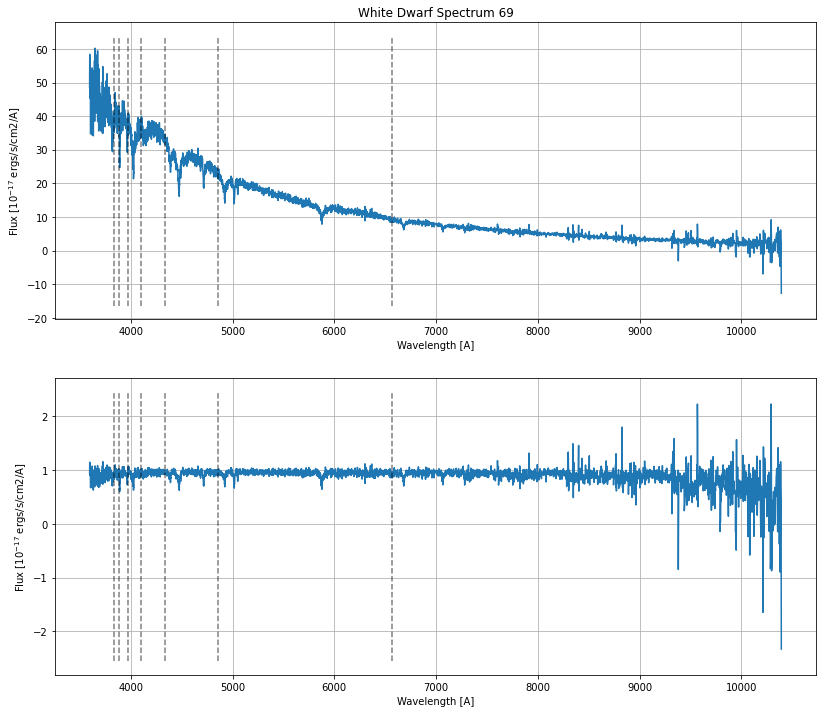

In [16]:
id_ = []
balmer_lines = [6562.79, 4861.35, 4340.47, 4101.73, 3970.07, 3889.06, 3835.40]

for i in tqdm(range(len(catalog))):
    id_.append(i)

    plt.figure(figsize=(30,12))
    
    plt.subplot(2,2,1)
    plt.plot(catalog['wd_wl'][i], catalog['wd_fl'][i])
    min_, max_ = plt.ylim()
    plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
    plt.grid()
    plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
    plt.xlabel(r'Wavelength [A]')
    plt.title('White Dwarf Spectrum {}'.format(i))
    
    plt.subplot(2,2,3)
    plt.plot(catalog['wd_wl'][i], pseudonormalize(catalog['wd_fl'][i]))
    min_, max_ = plt.ylim()
    plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
    plt.grid()
    plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
    plt.xlabel(r'Wavelength [A]')
    #plt.title('White Dwarf Spectrum {}'.format(i))
    plt.savefig('spectra/sdss4/wd{}.png'.format(i))

    
catalog['wd_catalog_id'] = id_

69


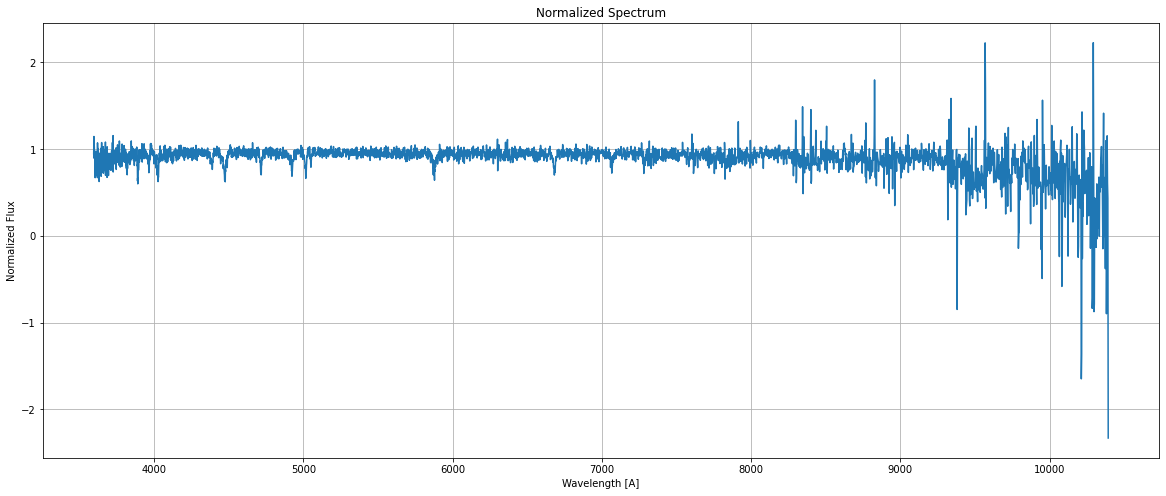

In [17]:
print(i)
nwl = catalog['wd_wl'][i]
nfl = catalog['wd_fl'][i]
cont = pseudonormalize(nfl, 50)

plt.figure(figsize=(20,8))

plt.plot(nwl, cont)
plt.grid()
plt.ylabel(r'Normalized Flux')
plt.xlabel(r'Wavelength [A]')
plt.title('Normalized Spectrum')
ax = plt.gca()

plt.show()

In [18]:
not_da = np.array([1,6,7,12,14,15,16,21,23,28,30,31,32,33,35,36,37,38,39,42,44,48,50,52,53,55,58,60,66,68,69])
reject = catalog[not_da]

catalog.remove_rows(not_da)

print([np.any(np.isnan(catalog['wd_ivar'][i])) for i in range(len(catalog))])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [28]:
from astropy.table import Table, Column, MaskedColumn, join


teff_prior = True

try:
    nug = Table.read('data/nug.fits')
    print(catalog['wd_source_id'])
    catalog = join(catalog, nug, keys='wd_source_id', join_type='inner')
    print('worked')
except:
    teff_prior = False

    wd_source_id   
-------------------
 754878504143019136
 608113531698574592
 611167150367477888
2500203890109764608
 667328516391473920
 635639045092641280
 647300160472509184
 642837135401004672
 649472245695986816
2424880574738721408
1266120732108636160
                ...
1011119104880885376
1211355290583415168
1212425463290645504
1204247364523767168
1766826194114406656
 722128828755291392
 724012189094256512
 861577625059010176
 593918802224747776
 599615711270729984
 908364559240386944
Length = 39 rows
worked


In [29]:
from lmfit import Parameters, fit_report, minimize

calculate_rvs = True


if calculate_rvs:
    rvs = []
    e_rvs = []
    
    catalog['rv_id'] = np.ones(len(catalog))

    teff = []
    logg = []
    e_teff = []
    e_logg = []

    redchi = []
    drops = []
    figs = []

    return_obj = []

    #catalog['wd_ivar'] = [catalog['wd_ivar'][i]  for i in range(len(catalog))]

    for i in tqdm(range(len(catalog))):
        print(catalog['phot_teff'][i])
        corvmodel = corv.models.make_koester_model(names = ['a','b','g','d'])

        fl = np.array(catalog['wd_fl'][i])

        #for j in range(len(fl)):
        #    if fl[j] < 0:
        #        fl[j] = 0
        
        if teff_prior:
            corvmodel.params['teff'].value = catalog['phot_teff'][i]

        param_res, rv_res, rv_init = corv.fit.fit_corv(np.array(catalog['wd_wl'][i]), fl, np.array(catalog['wd_ivar'][i]), corvmodel, catalog['phot_teff'][i])

        if rv_res.params['teff'].stderr == None:
            rv_res.params['teff'].stderr = 1e-6
        if rv_res.params['logg'].stderr == None:
            rv_res.params['logg'].stderr = 1e-6
        if rv_res.params['RV'].stderr == None:
            rv_res.params['RV'].stderr = 1e-6

        f = corv.utils.lineplot(np.array(catalog['wd_wl'][i]), np.array(catalog['wd_fl'][i]), np.array(catalog['wd_ivar'][i]), corvmodel, rv_res.params, gap = 0.3, printparams = True,
                 figsize = (6, 5))

        f.suptitle('%d : %2.2f +/- %2.2f' % (catalog['wd_catalog_id'][i], rv_res.params['RV'].value, rv_res.params['RV'].stderr))
        figs.append(f)

        #f.savefig('spectra/corvfits/corvfit{}.jpg'.format(i))

        teff.append(rv_res.params['teff'].value)
        logg.append(rv_res.params['logg'].value)
        e_teff.append(rv_res.params['teff'].stderr)
        e_logg.append(rv_res.params['logg'].stderr)

        rvs.append(rv_res.params['RV'].value)
        e_rvs.append(rv_res.params['RV'].stderr)
        redchi.append(rv_res.redchi)

        return_obj.append(rv_res)
        
        catalog['rv_id'][i] = i



    #catalog.remove_rows(drops)
    catalog['rv'] = rvs
    catalog['e_rv'] = e_rvs

    catalog['corv_logg'] = logg
    catalog['corv_teff'] = teff
    catalog['e_teff'] = e_teff
    catalog['e_logg'] = e_logg
    
    catalog['e_rv'][catalog['e_rv'] == None] = 1e-6
    catalog['rechi'] = redchi
    catalog['figs'] = figs
    
else:
    rv_cat = Table.read('data/wd_rvs.fits')
    
    catalog['rv'] = rv_cat['rv']
    catalog['e_rv'] = rv_cat['e_rv']

  0%|                                                                                    | 0/39 [00:00<?, ?it/s]

8830.334172987781


AttributeError: 'Model' object has no attribute 'params'

In [ ]:
print(len(catalog))
#print(len(rvs))
#catalog = catalog[catalog['rechi'] < 2.5]
#catalog = catalog[(catalog['rv'] / catalog['e_rv']) > 5]
#catalog = catalog[catalog['rv'] < 1000]

if calculate_rvs:
    for i in range(len(catalog)):
        catalog['figs'][i].savefig('spectra/corvfits/corvfit{}.jpg'.format(catalog['wd_catalog_id'][i]))
        
    catalog.remove_columns(['figs'])
    

In [ ]:
#catalog[['e_rv', 'e_logg', 'e_teff']].pprint(max_lines=-1)

In [ ]:
catalog['e_rv'] = np.array(catalog['e_rv']).astype(float)

In [ ]:
'''

plt.figure(figsize=(25,16))


has_erv = []
for i in range(len(catalog)):
    if catalog['e_rv'][i] > 1e-4:
        has_erv.append([i, np.mean(catalog['wd_ivar'][i])])
        
has_erv = np.array(has_erv).T

num = np.array([i for i in range(len(catalog))])
mean_ivar = np.array([np.mean(catalog['wd_ivar'][i]) for i in range(len(catalog))])

'''
#===============================================
#                Plot One
#===============================================
'''

i = [0,5]

plt.subplot(3,2,1)
plt.scatter(num, mean_ivar, label = 'No Error Reported')
plt.scatter(has_erv[0], has_erv[1], label = 'Error Reported')

#plt.hlines(1, 0, 40)
plt.grid()
plt.ylabel(r'Mean ivar')
plt.xlabel(r'Spectrum Number')
#plt.title('White Dwarf Spectrum')
plt.legend()

plt.subplot(3,2,2)

plt.scatter(num, mean_ivar, label = 'No Error Reported')
plt.scatter(has_erv[0], has_erv[1], label = 'Error Reported')

#plt.hlines(1, 0, 40)
plt.grid()
plt.ylabel(r'Mean ivar')
plt.xlabel(r'Spectrum Number')
plt.legend()

'''
#===============================================
#    Plot Two
#===============================================
'''

plt.subplot(3,2,3)

plt.plot(catalog['wd_wl'][i[0]], catalog['wd_fl'][i[0]])
plt.text(0.05, 0.14, 'Redchi: {}'.format(round(catalog['rechi'][i[0]], 3)), fontsize=12,
                transform = plt.gca().transAxes)

plt.grid()
plt.ylabel(r'ivar')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (No Error Reported)'.format(i[0]))

plt.subplot(3,2,4)
color = plt.cm.coolwarm(catalog['wd_ivar'][i[0]])
plt.scatter(catalog['wd_wl'][i[0]], catalog['wd_fl'][i[0]], c=catalog['wd_ivar'][i[0]], cmap = 'coolwarm', s=10)

plt.grid()
plt.ylabel(r'Flux')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (No Error Reported)'.format(i[0]))
plt.colorbar(label='ivar')

'''
#===============================================
#    Plot Three
#===============================================
'''

plt.subplot(3,2,5)

plt.plot(catalog['wd_wl'][i[1]], catalog['wd_fl'][i[1]])
plt.text(0.05, 0.14, 'Redchi: {}'.format(round(catalog['rechi'][i[1]], 3)), fontsize=12,
                transform = plt.gca().transAxes)


plt.grid()
plt.ylabel(r'ivar')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (Error Reported)'.format(i[1]))

plt.subplot(3,2,6)
#color = plt.cm.coolwarm(catalog['wd_ivar'][i])
plt.scatter(catalog['wd_wl'][i[1]], catalog['wd_fl'][i[1]], c=catalog['wd_ivar'][i[1]], cmap = 'coolwarm', s=10)

plt.grid()
plt.ylabel(r'Flux')
plt.xlabel(r'Wavelength')
plt.title('Spectrum Number {} (Error Reported)'.format(i[1]))
plt.legend()
plt.colorbar(label='ivar')


plt.show()

'''

In [ ]:
print(catalog[['rv','e_rv']])

'''
bad_corv = np.array([37, 38])
bad_corv = np.array([3, 5, 10, 23, 26, 27, 31, 37, 38, 39, 42, 43])
catalog.remove_rows(bad_corv)
'''

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))
#axes.grid()
axes.hist(catalog['ms_rv'], bins = 15, alpha=0.5, color='black', label='Main sequence')
#axes.hist(catalog['rv'], bins = 15, alpha=0.5, color='red', label='White dwarf')
ymin, ymax = axes.get_ylim()
axes.vlines(np.mean(catalog['ms_rv']), ymin, ymax, linestyles='dashed')
#axes.vlines(np.mean(catalog['rv']), ymin, ymax, linestyles='dashed', color='red')

#axes[0].set_title('Gravitational Redshift', fontsize=20)
axes.set_xlabel(r'$RV [km/s]$', fontsize=18)
axes.legend()

In [ ]:
catalog['g_redshift'] = catalog['rv'] - catalog['ms_rv']
catalog['eg_redshift'] = catalog['ms_erv'] + catalog['e_rv']

#catalog = catalog[catalog['g_redshift'] > -100]
#catalog = catalog[catalog['g_redshift'] < 100]

print(np.mean(catalog['g_redshift']))
print(len(catalog))


plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['g_redshift'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['g_redshift']), ymin, ymax, linestyles='dashed')
plt.title('Gravitational Redshift', fontsize=20)
plt.xlabel(r'$RV_{MS} - RV_{WD}$', fontsize=18)

In [ ]:
for col in catalog.columns:
    if catalog[col].dtype == object: print(col)

In [ ]:
catalog.remove_columns(['wd_wl', 'wd_fl', 'wd_ivar'])

catalog.write('data/03_wd_rv.fits', format='fits', overwrite=True)